<a href="https://colab.research.google.com/github/KasiaGW/Receptor-Affinity-Prediction-Kaggle-Hackathon-team-project-/blob/main/AGH_ML_Hackathon_Template_20250618.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b>Realizacja</b>

## Funkcje uzyte, importy

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from scipy.stats import chi2_contingency
from itertools import combinations

In [ ]:
from sklearn.linear_model import (
    LinearRegression, Ridge, RidgeCV, SGDRegressor, Lasso, LassoCV, ElasticNet, ElasticNetCV, HuberRegressor
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

In [ ]:
# Przedstaw summary
# Typy danych
# Dane liczbowe: podstawowe statystyki
# Dane kategoryczne: ilosc unikalnych wartosci
# brakujace wartosci, duplikaty

def profile_data(df):
    pd.set_option('display.float_format', '{:.2f}'.format)
    # Podstawowe informacje
    n_rows, n_cols = df.shape
    num_cols = df.select_dtypes(include=['number']).columns.tolist()
    text_cols = df.select_dtypes(include=['object', 'string']).columns.tolist()

    print(f"üìä Profil danych:")
    print(f"‚û°Ô∏è Liczba wierszy: {n_rows}")
    print(f"‚û°Ô∏è Liczba zmiennych: {n_cols}")
    print(f"üî¢ Liczba zmiennych numerycznych: {len(num_cols)}")
    print(f"üî§ Liczba zmiennych tekstowych: {len(text_cols)}")
    print(f"üî¢ Zmienne numeryczne ({len(num_cols)}): {num_cols}")
    print(f"üî§ Zmienne nienumeryczne ({len(df.columns) - len(num_cols)}): {[col for col in df.columns if col not in num_cols]}")

    # tworzenie profilu
    profile = pd.DataFrame(index=df.columns)

    # Typ danych
    profile["dtype"] = df.dtypes

    # Liczba brak√≥w i procent brak√≥w
    profile["missing_count"] = df.isnull().sum()
    profile["missing_percent"] = 100 * df.isnull().mean()

    # Liczba unikalnych warto≈õci
    profile["n_unique"] = df.nunique()

    # Najczƒôstsza warto≈õƒá
    profile["top_value"] = df.mode().iloc[0]

    # Liczno≈õƒá najczƒôstszej warto≈õci
    profile["top_freq"] = df.apply(lambda x: x.value_counts().iloc[0] if not x.isnull().all() else None)

    # Statystyki tylko dla kolumn numerycznych
    numeric_cols = df.select_dtypes(include=['number'])
    profile.loc[numeric_cols.columns, "mean"] = numeric_cols.mean()
    profile.loc[numeric_cols.columns, "min"] = numeric_cols.min()
    profile.loc[numeric_cols.columns, "max"] = numeric_cols.max()
    profile.loc[numeric_cols.columns, "25%"] = numeric_cols.quantile(0.25)
    profile.loc[numeric_cols.columns, "50%"] = numeric_cols.median()
    profile.loc[numeric_cols.columns, "75%"] = numeric_cols.quantile(0.75)
    profile.loc[numeric_cols.columns, "std"] = numeric_cols.std()

    # Informacja o duplikatach w ca≈Çym DataFrame
    n_duplicates = df.duplicated().sum()
    print(f"üîÅ Liczba zduplikowanych wierszy: {n_duplicates} ({n_duplicates / len(df) * 100:.2f}%)")

    # Sortowanie: numeryczne, daty, inne
    datetime_cols = df.select_dtypes(include=["datetime"]).columns.tolist()
    other_cols = [col for col in df.columns if col not in num_cols + datetime_cols]
    ordered_cols = num_cols + datetime_cols + other_cols
    profile = profile.loc[ordered_cols]

    return profile.round(2)

In [ ]:
# Wizualizacje
def plot_numerical_grid(df):
    print("Rozklady zmiennych numerycznych.")
    num_cols = df.select_dtypes(include=['number']).columns

    if len(num_cols) == 0:
        print("Brak zmiennych numerycznych.")
        return

    n = len(num_cols)
    ncols = 2
    nrows = math.ceil(n)

    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(12, 4 * n))
    axes = axes.reshape(n, 2)

    for i, col in enumerate(num_cols):
        if df[col].dropna().empty:
            axes[i, 0].set_visible(False)
        else:
            sns.histplot(df[col].dropna(), ax=axes[i, 0], kde=True, bins=30)
            axes[i, 0].set_title(f"Histogram: {col}")

        if df[col].dropna().empty:
            axes[i, 1].set_visible(False)
        else:
            sns.boxplot(x=df[col].dropna(), ax=axes[i, 1])
            axes[i, 1].set_title(f"Boxplot: {col}")

    plt.tight_layout()
    plt.show()

In [ ]:
# Feature importance
def plot_feature_importance(model, model_name, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10,5))
    plt.title(f"Wa≈ºno≈õƒá cech: {model_name}")
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=90)
    plt.tight_layout()
    plt.show()

In [ ]:
# Funkcja do metryk
def print_regression_metrics(y_true, y_pred, model_name="Model"):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print(f"Metryki dla {model_name}:")
    print(f"  R2:    {r2:.4f}")
    print(f"  RMSE:  {rmse:.4f}")
    print(f"  MAPE:  {mape:.4f}")
    print()

## Pobranie i przygotowanie danych

Pobranie danych, zrozumienie struktury, polaczenie danych ZINC i CHEMBL (usuniecie duplikatow - pierwszenstwo ZINC), pobranie deskryptorow z bazy, sprawdzenie brakujacych wartosci, dobor deskryptorow.

In [ ]:
# pobranie i rozpakowanie danych na dysk google
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c receptor-affinity-prediction-hackaton
!unzip -q receptor-affinity-prediction-hackaton.zip

Saving kaggle.json to kaggle.json
  0% 0.00/59.9M [00:00<?, ?B/s]
100% 59.9M/59.9M [00:00<00:00, 991MB/s]


In [ ]:
# wczytanie ZINC i CHEMBL
zinc_raw = pd.read_csv('ZINC_data_5HT2A.csv')
chembl_raw = pd.read_csv('Chembl_data_5HT2A.csv')

In [ ]:
# kolumny potrzebne do dalszych operacji
zinc = zinc_raw.copy()
zinc = zinc[['zinc_id', 'smiles', 'pKi_numeric']]
chembl = chembl_raw.copy()
chembl = chembl[['Smiles', 'pKi_numeric', 'Standard Type', 'Standard Relation', 'Standard Value']]

In [ ]:
# chembl : odfiltrowac relation == '=' [inne maja dane brakujace lub niedokladne]
chembl = chembl.loc[chembl['Standard Relation'] == "'='"]

In [ ]:
# obliczamy PKI wedlug wzoru
chembl['PKI'] = -np.log10(chembl['Standard Value'] / 1e9)

In [ ]:
# wyswietl duplikaty na Smiles
chembl[chembl.duplicated(subset=['Smiles', 'PKI'], keep=False)].sort_values(by='Smiles')

Smiles  pKi_numeric  \
4836            C1=CC2CNCCN3C[C@@H]4CCC[C@@H]4C(=C1)C23         6.83   
2952            C1=CC2CNCCN3C[C@@H]4CCC[C@@H]4C(=C1)C23         6.83   
2437                     CC(N)Cc1c2c(c(Br)c3c1OCC3)OCC2         9.32   
250                      CC(N)Cc1c2c(c(Br)c3c1OCC3)OCC2         9.32   
1199                          CC1(CN)c2ccccc2Cc2ccccc21         7.19   
...                                                 ...          ...   
2923  c1ccc(-c2nc3cc(CCN4CCN(c5ccccc5)CC4)ccc3[nH]2)cc1         6.12   
2928                  c1ccc(CNCC2c3ccccc3Cc3ccccc32)cc1         6.14   
2378                  c1ccc(CNCC2c3ccccc3Cc3ccccc32)cc1         6.14   
2825       c1ccc2c(N3CCN(CCc4ccc5[nH]nnc5c4)CC3)cccc2c1         7.98   
4022       c1ccc2c(N3CCN(CCc4ccc5[nH]nnc5c4)CC3)cccc2c1         7.98   

     Standard Type Standard Relation  Standard Value       PKI  
4836            Ki               '='          149.00  6.826814  
2952            Ki               '='          149.00  6.826814  
2437            Ki               '='            0.48  9.318759  
250             Ki               '='            0.48  9.318759  
1199            Ki               '='           65.00  7.187087  
...            ...               ...             ...       ...  
2923            Ki               '='          758.58  6.119999  
2928            Ki               '='          721.00  6.142065  
2378            Ki               '='          721.00  6.142065  
2825            Ki               '='           10.47  7.980053  
4022            Ki               '='           10.47  7.980053  

[254 rows x 6 columns]

In [ ]:
chembl.loc[chembl['pKi_numeric'] != chembl['PKI']]

Smiles  pKi_numeric  \
0     CC(=O)c1c(OCCCCN2CCN(c3cccc(F)c3)CC2)ccc2c(C)c...         6.40   
1                           COc1c2c(c(CCN)c3c1OCC3)CCO2         5.35   
2          COc1ccc2[nH]cc(CCNCc3ccc(-c4cn[nH]c4)o3)c2c1         7.55   
3          Oc1ccc(-c2ccc(CNCCc3c[nH]c4cc(F)ccc34)o2)cc1         7.02   
4     O=C(NC/C=C/CN1CCN(c2cccc(Cl)c2Cl)CC1)c1ccc(-c2...         7.21   
...                                                 ...          ...   
5447                      CCNCc1ccc(Cl)c(-c2ccccc2OC)c1         6.04   
5448  C[C@H]1C[C@H](NS(=O)(=O)c2cc3ccc(Cl)cc3s2)CN1C...         8.38   
5449   CC(=O)Nc1ccc(OCCCN2CCC(c3noc4cc(F)ccc34)CC2)cc1F         7.38   
5450             OCCOCCN1CCN(C2=Nc3ccccc3Sc3ccccc32)CC1         6.92   
5453                       COc1cc(C[C@@H](C)N)c(OC)cc1I         8.17   

     Standard Type Standard Relation  Standard Value       PKI  
0               Ki               '='         400.000  6.397940  
1               Ki               '='        4443.000  5.352324  
2               Ki               '='          28.000  7.552842  
3               Ki               '='          96.000  7.017729  
4               Ki               '='          62.400  7.204815  
...            ...               ...             ...       ...  
5447            Ki               '='         910.000  6.040959  
5448            Ki               '='           4.169  8.379968  
5449            Ki               '='          41.800  7.378824  
5450            Ki               '='         120.230  6.919987  
5453            Ki               '='           6.800  8.167491  

[3856 rows x 6 columns]

In [ ]:
# duplikaty: 1. usuwamy duplikaty gdzie Smiles i PKI sa identyczne [zostawiamy pierwszy]
# duplikaty: 2. usuwamy wszystkie pary rekordow, gdzie Smiles jest ten sam, ale PKI jest rozne
chembl_clean = chembl.drop_duplicates(subset=['Smiles', 'PKI'], keep='first')
chembl_clean = chembl_clean.drop_duplicates(subset=['Smiles'], keep=False)

In [ ]:
profile_data(chembl_clean)

üìä Profil danych:
‚û°Ô∏è Liczba wierszy: 3141
‚û°Ô∏è Liczba zmiennych: 6
üî¢ Liczba zmiennych numerycznych: 3
üî§ Liczba zmiennych tekstowych: 3
üî¢ Zmienne numeryczne (3): ['pKi_numeric', 'Standard Value', 'PKI']
üî§ Zmienne nienumeryczne (3): ['Smiles', 'Standard Type', 'Standard Relation']
üîÅ Liczba zduplikowanych wierszy: 0 (0.00%)


dtype  missing_count  missing_percent  n_unique  \
pKi_numeric        float64              2             0.06       492   
Standard Value     float64              0             0.00      1655   
PKI                float64              0             0.00      1655   
Smiles              object              0             0.00      3141   
Standard Type       object              0             0.00         1   
Standard Relation   object              0             0.00         1   

                                                           top_value  \
pKi_numeric                                                     6.40   
Standard Value                                                398.11   
PKI                                                             6.20   
Smiles             Br.Cc1cccc(-c2c(O)c(O)cc3c2CCN(C)CC3c2cccc(C)c...   
Standard Type                                                     Ki   
Standard Relation                                                '='   

                   top_freq     mean  min          max  25%   50%    75%  \
pKi_numeric              32     7.27 4.00        11.00 6.37  7.28   8.09   
Standard Value           25 32737.69 0.01 100000000.00 8.15 53.00 433.00   
PKI                      25     7.27 1.00        11.00 6.36  7.28   8.09   
Smiles                    1      NaN  NaN          NaN  NaN   NaN    NaN   
Standard Type          3141      NaN  NaN          NaN  NaN   NaN    NaN   
Standard Relation      3141      NaN  NaN          NaN  NaN   NaN    NaN   

                         std  
pKi_numeric             1.16  
Standard Value    1784282.54  
PKI                     1.17  
Smiles                   NaN  
Standard Type            NaN  
Standard Relation        NaN

In [ ]:
# polaczyc zinc i chembl:
# dodac zinc_id = 'chembl' do chembl, zeby je zaznaczyc
# dostosuj nazwy kolumn
# odfiltruj smiles z chembl_clean, ktore sa juz w ZINC

chembl_clean['zinc_id'] = 'chembl'
chembl_clean.rename(columns={'Smiles': 'smiles'}, inplace=True)
zinc.rename(columns={'pKi_numeric': 'PKI'}, inplace=True)
chembl_clean = chembl_clean.loc[~chembl_clean['smiles'].isin(zinc['smiles'])]

zinc_chembl = pd.concat([zinc[['zinc_id', 'smiles', 'PKI']], chembl_clean[['zinc_id', 'smiles', 'PKI']]])

In [ ]:
zinc_chembl[zinc_chembl.duplicated(subset=['smiles'], keep=False)].sort_values(by='smiles')

Empty DataFrame
Columns: [zinc_id, smiles, PKI]
Index: []

In [ ]:
profile_data(zinc_chembl)

üìä Profil danych:
‚û°Ô∏è Liczba wierszy: 4887
‚û°Ô∏è Liczba zmiennych: 3
üî¢ Liczba zmiennych numerycznych: 1
üî§ Liczba zmiennych tekstowych: 2
üî¢ Zmienne numeryczne (1): ['PKI']
üî§ Zmienne nienumeryczne (2): ['zinc_id', 'smiles']
üîÅ Liczba zduplikowanych wierszy: 0 (0.00%)


dtype  missing_count  missing_percent  n_unique  \
PKI      float64              0             0.00      1731   
zinc_id   object              0             0.00      2878   
smiles    object              0             0.00      4887   

                                                 top_value  top_freq  mean  \
PKI                                                   6.00        46  7.18   
zinc_id                                             chembl      2010   NaN   
smiles   Br.Cc1cccc(-c2c(O)c(O)cc3c2CCN(C)CC3c2cccc(C)c...         1   NaN   

         min   max  25%  50%  75%  std  
PKI     1.00 11.00 6.32 7.10 7.94 1.15  
zinc_id  NaN   NaN  NaN  NaN  NaN  NaN  
smiles   NaN   NaN  NaN  NaN  NaN  NaN

In [ ]:
smiles = zinc_chembl[['smiles', 'PKI']]

In [ ]:
# pobrac deskryptory dla naszych smiles
# wczytaj deskryptory
# zmerguj df smiles i deskryptory

deskryptory = pd.read_csv('Mordred_descriptors_database.csv')


/tmp/ipython-input-22-2580666367.py:5: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13,14,15,16,54,55,56,57,58,59,60,61,62,136,137,138,139,140,141,142,145,146,147,148,149,150,151,153,154,155,156,157,158,159,160,163,164,165,166,167,168,169,172,173,174,175,176,177,178,181,182,183,184,185,186,187,190,191,192,193,194,195,196,199,200,201,202,203,204,205,208,209,210,211,212,213,214,217,218,219,220,221,222,223,226,227,228,229,230,231,232,234,235,236,237,238,239,240,241,242,261,262,263,264,265,266,267,268,269,342,343,344,345,346,347,348,349,352,353,354,355,356,357,358,361,362,363,364,365,366,367,369,370,371,372,373,374,375,376,379,380,381,382,383,384,385,388,389,390,391,392,393,394,397,398,399,400,401,402,403,406,407,408,409,410,411,412,415,416,417,418,419,420,421,424,425,426,427,428,429,430,433,434,435,436,437,438,439,442,443,444,445,446,447,448,450,451,452,453,454,455,456,458,459,460,461,462,463,464,466,467,468,469,470,471,472,474,475,476,477,478,479,480,482,483,484,485,486,487,488,490,491,492,

In [ ]:
smiles.shape

(4887, 2)

In [ ]:
deskryptory.shape

(7009, 1614)

In [ ]:
raw_data = pd.merge(smiles, deskryptory, on='smiles', how='left')

In [ ]:
raw_data.shape

(4887, 1615)

In [ ]:
raw_data.to_csv('raw_data.csv', index=False)

In [ ]:
missing = raw_data.isna().sum()

In [ ]:
# nie ma brakujacych wartosci
missing.loc[missing > 0]

Series([], dtype: int64)

In [ ]:
# Sprawdzamy czy sa zmienne niezmienne
nunique = raw_data.nunique()

In [ ]:
nunique.loc[nunique == 1]

ABC           1
ABCGG         1
nB            1
NsLi          1
NssBe         1
             ..
n11FaHRing    1
n4FARing      1
n5FARing      1
n4FAHRing     1
n5FAHRing     1
Length: 225, dtype: int64

In [ ]:
# usun kolumny z ta sama wartoscia w kazdym wierszu
cols_to_drop = nunique.loc[nunique == 1].index.tolist()
raw_data_2 = raw_data.drop(columns=cols_to_drop)

In [ ]:
raw_data_2.shape

(4887, 1390)

In [ ]:
profile_data(raw_data_2)

üìä Profil danych:
‚û°Ô∏è Liczba wierszy: 4887
‚û°Ô∏è Liczba zmiennych: 1390
üî¢ Liczba zmiennych numerycznych: 631
üî§ Liczba zmiennych tekstowych: 757
üî¢ Zmienne numeryczne (631): ['PKI', 'nAcid', 'nBase', 'nAromAtom', 'nAromBond', 'nAtom', 'nHeavyAtom', 'nSpiro', 'nBridgehead', 'nHetero', 'nH', 'nC', 'nN', 'nO', 'nS', 'nP', 'nF', 'nCl', 'nBr', 'nI', 'nX', 'ATS0dv', 'ATS1dv', 'ATS2dv', 'ATS3dv', 'ATS4dv', 'ATS5dv', 'ATS6dv', 'ATS7dv', 'ATS8dv', 'ATS0d', 'ATS1d', 'ATS2d', 'ATS3d', 'ATS4d', 'ATS5d', 'ATS6d', 'ATS7d', 'ATS8d', 'ATS0Z', 'ATS1Z', 'ATS2Z', 'ATS3Z', 'ATS4Z', 'ATS5Z', 'ATS6Z', 'ATS7Z', 'ATS8Z', 'ATS0m', 'ATS1m', 'ATS2m', 'ATS3m', 'ATS4m', 'ATS5m', 'ATS6m', 'ATS7m', 'ATS8m', 'ATS0v', 'ATS1v', 'ATS2v', 'ATS3v', 'ATS4v', 'ATS5v', 'ATS6v', 'ATS7v', 'ATS8v', 'ATS0se', 'ATS1se', 'ATS2se', 'ATS3se', 'ATS4se', 'ATS5se', 'ATS6se', 'ATS7se', 'ATS8se', 'ATS0pe', 'ATS1pe', 'ATS2pe', 'ATS3pe', 'ATS4pe', 'ATS5pe', 'ATS6pe', 'ATS7pe', 'ATS8pe', 'ATS0are', 'ATS1are', 'ATS2are', 'ATS3ar

/tmp/ipython-input-5-2461157667.py:36: UserWarning: Unable to sort modes: '<' not supported between instances of 'float' and 'str'
  profile["top_value"] = df.mode().iloc[0]


üîÅ Liczba zduplikowanych wierszy: 0 (0.00%)


dtype  missing_count  missing_percent  n_unique  \
PKI        float64              0             0.00      1731   
nAcid        int64              0             0.00         3   
nBase        int64              0             0.00         6   
nAromAtom    int64              0             0.00        24   
nAromBond    int64              0             0.00        22   
...            ...            ...              ...       ...   
AMID_X      object              0             0.00      1582   
RotRatio    object              0             0.00       348   
Vabc        object              0             0.00      3025   
VAdjMat     object              0             0.00        85   
mZagreb1    object              0             0.00       866   

                                                top_value  top_freq  mean  \
PKI                                                  6.00        46  7.18   
nAcid                                                0.00      4743  0.03   
nBase                                                1.00      4354  0.99   
nAromAtom                                           12.00      1386 12.82   
nAromBond                                           12.00      1370 13.24   
...                                                   ...       ...   ...   
AMID_X                                                0.0      1717   NaN   
RotRatio                                             0.00       188   NaN   
Vabc                             unknown atom type (Vabc)        40   NaN   
VAdjMat                                              6.21       273   NaN   
mZagreb1   divide by zero encountered in power (mZagreb1)       130   NaN   

           min   max   25%   50%   75%  std  
PKI       1.00 11.00  6.32  7.10  7.94 1.15  
nAcid     0.00  2.00  0.00  0.00  0.00 0.18  
nBase     0.00  5.00  1.00  1.00  1.00 0.39  
nAromAtom 0.00 30.00  9.00 12.00 16.00 4.42  
nAromBond 0.00 30.00 10.00 12.00 17.00 4.69  
...        ...   ...   ...   ...   ...  ...  
AMID_X     NaN   NaN   NaN   NaN   NaN  NaN  
RotRatio   NaN   NaN   NaN   NaN   NaN  NaN  
Vabc       NaN   NaN   NaN   NaN   NaN  NaN  
VAdjMat    NaN   NaN   NaN   NaN   NaN  NaN  
mZagreb1   NaN   NaN   NaN   NaN   NaN  NaN  

[1390 rows x 13 columns]

In [ ]:
# zostawiamy tylko zmienne wczytane jako numeryczne, oznacza to, ze nie bylo bledow i brakow w wyliczeniu tych deskryptorow
# zmienne wczytane jako str > brakujace wartosci liczbowe zostaly zastapione tekstem zawierajacym opis bledu
# i zrozumiane przez pandas jako tekst > faktycznie zawieraja brakujace wartosci
num_cols = raw_data_2.select_dtypes(include=['number']).columns.tolist()
raw_data_num = raw_data_2[num_cols + ['smiles']]

In [ ]:
profile_data(raw_data_num)

üìä Profil danych:
‚û°Ô∏è Liczba wierszy: 4887
‚û°Ô∏è Liczba zmiennych: 632
üî¢ Liczba zmiennych numerycznych: 631
üî§ Liczba zmiennych tekstowych: 1
üî¢ Zmienne numeryczne (631): ['PKI', 'nAcid', 'nBase', 'nAromAtom', 'nAromBond', 'nAtom', 'nHeavyAtom', 'nSpiro', 'nBridgehead', 'nHetero', 'nH', 'nC', 'nN', 'nO', 'nS', 'nP', 'nF', 'nCl', 'nBr', 'nI', 'nX', 'ATS0dv', 'ATS1dv', 'ATS2dv', 'ATS3dv', 'ATS4dv', 'ATS5dv', 'ATS6dv', 'ATS7dv', 'ATS8dv', 'ATS0d', 'ATS1d', 'ATS2d', 'ATS3d', 'ATS4d', 'ATS5d', 'ATS6d', 'ATS7d', 'ATS8d', 'ATS0Z', 'ATS1Z', 'ATS2Z', 'ATS3Z', 'ATS4Z', 'ATS5Z', 'ATS6Z', 'ATS7Z', 'ATS8Z', 'ATS0m', 'ATS1m', 'ATS2m', 'ATS3m', 'ATS4m', 'ATS5m', 'ATS6m', 'ATS7m', 'ATS8m', 'ATS0v', 'ATS1v', 'ATS2v', 'ATS3v', 'ATS4v', 'ATS5v', 'ATS6v', 'ATS7v', 'ATS8v', 'ATS0se', 'ATS1se', 'ATS2se', 'ATS3se', 'ATS4se', 'ATS5se', 'ATS6se', 'ATS7se', 'ATS8se', 'ATS0pe', 'ATS1pe', 'ATS2pe', 'ATS3pe', 'ATS4pe', 'ATS5pe', 'ATS6pe', 'ATS7pe', 'ATS8pe', 'ATS0are', 'ATS1are', 'ATS2are', 'ATS3are',

dtype  missing_count  missing_percent  n_unique  \
PKI        float64              0             0.00      1731   
nAcid        int64              0             0.00         3   
nBase        int64              0             0.00         6   
nAromAtom    int64              0             0.00        24   
nAromBond    int64              0             0.00        22   
...            ...            ...              ...       ...   
WPol         int64              0             0.00        78   
Zagreb1    float64              0             0.00       105   
Zagreb2    float64              0             0.00       217   
mZagreb2   float64              0             0.00       971   
smiles      object              0             0.00      4887   

                                                   top_value  top_freq   mean  \
PKI                                                     6.00        46   7.18   
nAcid                                                   0.00      4743   0.03   
nBase                                                   1.00      4354   0.99   
nAromAtom                                              12.00      1386  12.82   
nAromBond                                              12.00      1370  13.24   
...                                                      ...       ...    ...   
WPol                                                   48.00       223  44.03   
Zagreb1                                               166.00       170 147.27   
Zagreb2                                               192.00       101 174.38   
mZagreb2                                                4.89        47   6.03   
smiles     Br.Cc1cccc(-c2c(O)c(O)cc3c2CCN(C)CC3c2cccc(C)c...         1    NaN   

            min    max    25%    50%    75%   std  
PKI        1.00  11.00   6.32   7.10   7.94  1.15  
nAcid      0.00   2.00   0.00   0.00   0.00  0.18  
nBase      0.00   5.00   1.00   1.00   1.00  0.39  
nAromAtom  0.00  30.00   9.00  12.00  16.00  4.42  
nAromBond  0.00  30.00  10.00  12.00  17.00  4.69  
...         ...    ...    ...    ...    ...   ...  
WPol       7.00 126.00  36.00  45.00  52.00 11.77  
Zagreb1   38.00 362.00 122.00 154.00 174.00 36.55  
Zagreb2   40.00 445.00 145.00 182.00 205.00 43.97  
mZagreb2   2.21  15.78   4.97   6.26   7.06  1.45  
smiles      NaN    NaN    NaN    NaN    NaN   NaN  

[632 rows x 13 columns]

In [ ]:
raw_data_num.to_csv('raw_data_num.csv', index=False)

Rozklady zmiennych numerycznych.


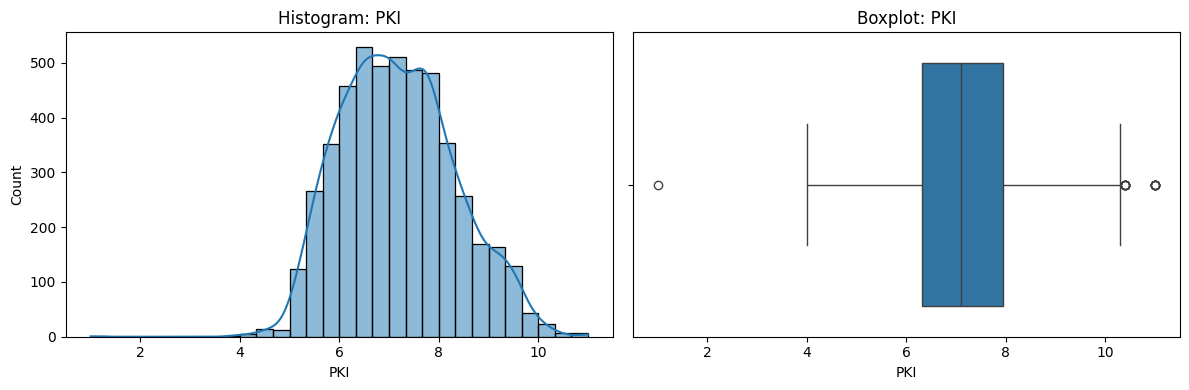

In [ ]:
plot_numerical_grid(raw_data_num[['PKI', 'smiles']])

## Przygotowanie danych do modelu

In [ ]:
# przygotowanie danych do modelu

y = raw_data_num['PKI']
X = raw_data_num.drop(columns=['PKI', 'smiles'])

# Podzia≈Ç
X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=42)


# Pipeline dla danych numerycznych
preprocessor = StandardScaler()

X_train_transformed = pd.DataFrame(
    preprocessor.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_transformed = pd.DataFrame(
    preprocessor.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

In [ ]:
import joblib
# 2. Zapis do pliku
joblib.dump(preprocessor, "preprocessor_scaler.pkl")

['preprocessor_scaler.pkl']

## REGRESJA - Trening modeli

In [ ]:
# Tworzenie modeli - liniowe
regr = LinearRegression()
ridge = Ridge()
ridgeCV = RidgeCV()
SGDregr = SGDRegressor(max_iter=1000, tol=1e-3)
lasso = Lasso()
lassoCV = LassoCV()
elastic = ElasticNet()
elasticCV = ElasticNetCV()
huber = HuberRegressor()

In [ ]:
# Trenowanie modeli - liniowe
regr.fit(X_train_transformed, y_train)
ridge.fit(X_train_transformed, y_train)
ridgeCV.fit(X_train_transformed, y_train)
SGDregr.fit(X_train_transformed, y_train)
lasso.fit(X_train_transformed, y_train)
lassoCV.fit(X_train_transformed, y_train)
elastic.fit(X_train_transformed, y_train)
elasticCV.fit(X_train_transformed, y_train)
huber.fit(X_train_transformed, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5134901717924549, tolerance: 0.4126692140128152
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7654711539439631, tolerance: 0.4126692140128152
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7593775333293706, tolerance: 0.4126692140128152
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: Converge

HuberRegressor()

In [ ]:
# Predykcje na X_test - liniowe
y_pred_regr = regr.predict(X_test_transformed)
y_pred_ridge = ridge.predict(X_test_transformed)
y_pred_ridgeCV = ridgeCV.predict(X_test_transformed)
y_pred_SGD = SGDregr.predict(X_test_transformed)
y_pred_lasso = lasso.predict(X_test_transformed)
y_pred_lassoCV = lassoCV.predict(X_test_transformed)
y_pred_elastic = elastic.predict(X_test_transformed)
y_pred_elasticCV = elasticCV.predict(X_test_transformed)
y_pred_huber = huber.predict(X_test_transformed)

In [ ]:
# Metryki modeli liniowych
print_regression_metrics(y_test, y_pred_regr, "LinearRegression")
print_regression_metrics(y_test, y_pred_ridge, "Ridge")
print_regression_metrics(y_test, y_pred_ridgeCV, "RidgeCV")
print_regression_metrics(y_test, y_pred_SGD, "SGDRegressor")
print_regression_metrics(y_test, y_pred_lasso, "Lasso")
print_regression_metrics(y_test, y_pred_lassoCV, "LassoCV")
print_regression_metrics(y_test, y_pred_elastic, "ElasticNet")
print_regression_metrics(y_test, y_pred_elasticCV, "ElasticNetCV")
print_regression_metrics(y_test, y_pred_huber, "HuberRegressor")

Metryki dla LinearRegression:
  R2:    -4025.5590
  RMSE:  73.8111
  MAPE:  0.6941

Metryki dla Ridge:
  R2:    0.4636
  RMSE:  0.8519
  MAPE:  0.0889

Metryki dla RidgeCV:
  R2:    0.4581
  RMSE:  0.8563
  MAPE:  0.0897

Metryki dla SGDRegressor:
  R2:    -70367072515259107377152.0000
  RMSE:  308559884795.3343
  MAPE:  4971124960.0171

Metryki dla Lasso:
  R2:    -0.0005
  RMSE:  1.1635
  MAPE:  0.1356

Metryki dla LassoCV:
  R2:    0.4518
  RMSE:  0.8612
  MAPE:  0.0897

Metryki dla ElasticNet:
  R2:    -0.0005
  RMSE:  1.1635
  MAPE:  0.1356

Metryki dla ElasticNetCV:
  R2:    0.4539
  RMSE:  0.8596
  MAPE:  0.0897

Metryki dla HuberRegressor:
  R2:    0.4089
  RMSE:  0.8943
  MAPE:  0.0905



In [ ]:
# Tworzenie modeli - XGBoost
""" Pierwsza wersja XGBRegressor:
xgb_regr = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,        # liczba drzew (wiƒôksza = mocniejsze, wolniejsze)
    learning_rate=0.1,       # tempo uczenia (mniejsze = wolniejsze ale bardziej dok≈Çadne)
    max_depth=3,             # maksymalna g≈Çƒôboko≈õƒá drzewa (wiƒôksza = bardziej skomplikowany model)
    subsample=0.8,           # procent pr√≥bek u≈ºywanych w ka≈ºdym drzewie (np. 0.8)
    colsample_bytree=0.8,    # procent kolumn u≈ºywanych w ka≈ºdym drzewie
    reg_alpha=0.0,           # L1 regularizacja (wiƒôcej = bardziej "zeruje" cechy)
    reg_lambda=1.0,          # L2 regularizacja (wiƒôcej = bardziej "karze" du≈ºe wagi)
    random_state=42          # dla powtarzalno≈õci
)
R2 = 0.57
"""

xgb_regr = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,        # liczba drzew (wiƒôksza = mocniejsze, wolniejsze)
    learning_rate=0.01,       # tempo uczenia (mniejsze = wolniejsze ale bardziej dok≈Çadne)
    max_depth=10,             # maksymalna g≈Çƒôboko≈õƒá drzewa (wiƒôksza = bardziej skomplikowany model)
    subsample=0.8,           # procent pr√≥bek u≈ºywanych w ka≈ºdym drzewie (np. 0.8)
    colsample_bytree=0.8,    # procent kolumn u≈ºywanych w ka≈ºdym drzewie
    reg_alpha=0.0,           # L1 regularizacja (wiƒôcej = bardziej "zeruje" cechy)
    reg_lambda=1.0,          # L2 regularizacja (wiƒôcej = bardziej "karze" du≈ºe wagi)
    random_state=42          # dla powtarzalno≈õci
)

In [ ]:
# Trenowanie modeli - XGBoost
xgb_regr.fit(X_train_transformed, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Predykcje na X_test - XGBoost
y_pred_xgb = xgb_regr.predict(X_test_transformed)

In [ ]:
# Metryki XGBOOST
print_regression_metrics(y_test, y_pred_xgb, "XGBRegressor")

Metryki dla XGBRegressor:
  R2:    0.7103
  RMSE:  0.6261
  MAPE:  0.0579



In [ ]:
import joblib
# 2. Zapis do pliku
joblib.dump(xgb_regr, "xgboost_regressor.pkl")

['xgboost_regressor.pkl']

In [ ]:
# Wizualizacja
plt.figure(figsize=(10, 8))

# Dodaj ka≈ºdy model jako osobny scatter
plt.scatter(regr.predict(X_test_transformed), y_test, alpha=0.5, label='Linear', s=20)
plt.scatter(ridge.predict(X_test_transformed), y_test, alpha=0.5, label='Ridge', s=20)
plt.scatter(ridgeCV.predict(X_test_transformed), y_test, alpha=0.5, label='RidgeCV', s=20)
plt.scatter(SGDregr.predict(X_test_transformed), y_test, alpha=0.5, label='SGD', s=20)
plt.scatter(lasso.predict(X_test_transformed), y_test, alpha=0.5, label='Lasso', s=20)
plt.scatter(lassoCV.predict(X_test_transformed), y_test, alpha=0.5, label='LassoCV', s=20)
plt.scatter(elastic.predict(X_test_transformed), y_test, alpha=0.5, label='ElasticNet', s=20)
plt.scatter(elasticCV.predict(X_test_transformed), y_test, alpha=0.5, label='ElasticNetCV', s=20)
plt.scatter(huber.predict(X_test_transformed), y_test, alpha=0.5, label='Huber', s=20)
plt.scatter(xgb_regr.predict(X_test_transformed), y_test, alpha=0.5, label='XGBRegressor', s=20)

# Linia idealnego dopasowania
min_val = min(y_test.min(), regr.predict(X_test_transformed).min())
max_val = max(y_test.max(), regr.predict(X_test_transformed).max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1, label='Perfect prediction')

plt.xlabel('Predykcje')
plt.ylabel('Rzeczywiste warto≈õci')
plt.title('Por√≥wnanie modeli regresyjnych')
plt.legend()
plt.grid(True)
plt.show()

## REGRESJA - Usprawnienia modeli

### Eliminacja wsteczna cech nieistotnych

In [ ]:
# Eliminacja wsteczna cech nieistotnych

import statsmodels.api as sm

X_train_ols = X_train.copy()
X_train_ols = X_train_ols.values
X_train_ols = sm.add_constant(X_train_ols)

In [ ]:
X_train_numpy = X_train.values
X_train_numpy = sm.add_constant(X_train_numpy)
num_vars = len(X_train_numpy[0])
predictors = ['const'] + list(X_train.columns)
sl = 0.05
for i in range(0, num_vars):
  ols = sm.OLS(endog=y_train, exog=X_train_numpy).fit()
  max_pval = max(ols.pvalues.astype('float'))
  if max_pval > sl:
    for j in range(0, num_vars - i):
      if ols.pvalues[j].astype('float') == max_pval:
        X_train_numpy = np.delete(X_train_numpy, j, axis=1)
        predictors.remove(predictors[j])
print(ols.summary(xname=predictors))

KeyboardInterrupt: 

In [ ]:
len(predictors)

"""
# wykluczenie predyktorow (pozostawienie tylko tych z listy predictors nie poprawilo wynikow):
Metryki dla LinearRegression:
  R2:    0.2956
  RMSE:  0.9762
  MAPE:  0.0932

Metryki dla Ridge:
  R2:    0.4552
  RMSE:  0.8586
  MAPE:  0.0900

Metryki dla RidgeCV:
  R2:    0.4377
  RMSE:  0.8723
  MAPE:  0.0899

Metryki dla SGDRegressor:
  R2:    -2599476720484617216.0000
  RMSE:  1875416308.2780
  MAPE:  185898181.3238

Metryki dla Lasso:
  R2:    -0.0005
  RMSE:  1.1635
  MAPE:  0.1356

Metryki dla LassoCV:
  R2:    0.4532
  RMSE:  0.8601
  MAPE:  0.0904

Metryki dla ElasticNet:
  R2:    -0.0005
  RMSE:  1.1635
  MAPE:  0.1356

Metryki dla ElasticNetCV:
  R2:    0.4520
  RMSE:  0.8610
  MAPE:  0.0905

Metryki dla HuberRegressor:
  R2:    0.3952
  RMSE:  0.9046
  MAPE:  0.0918

Metryki dla XGBRegressor:
  R2:    0.5598
  RMSE:  0.7718
  MAPE:  0.0839
  """

### Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

"""
xgb_regr = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,        # liczba drzew (wiƒôksza = mocniejsze, wolniejsze)
    learning_rate=0.01,       # tempo uczenia (mniejsze = wolniejsze ale bardziej dok≈Çadne)
    max_depth=10,             # maksymalna g≈Çƒôboko≈õƒá drzewa (wiƒôksza = bardziej skomplikowany model)
    subsample=0.8,           # procent pr√≥bek u≈ºywanych w ka≈ºdym drzewie (np. 0.8)
    colsample_bytree=0.8,    # procent kolumn u≈ºywanych w ka≈ºdym drzewie
    reg_alpha=0.0,           # L1 regularizacja (wiƒôcej = bardziej "zeruje" cechy)
    reg_lambda=1.0,          # L2 regularizacja (wiƒôcej = bardziej "karze" du≈ºe wagi)
    random_state=42          # dla powtarzalno≈õci
)
"""
"""
Najlepsze parametry: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 1500} z Grid Search
Metryki dla Best XGBoostReg:
  R2:    0.7166
  RMSE:  0.6192
  MAPE:  0.0575
  """


from sklearn.model_selection import GridSearchCV

xgb_gpu = XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',      # üöÄ U≈ºycie GPU
    predictor='gpu_predictor',   # (opcjonalnie ‚Äî te≈º GPU do predykcji)
    n_estimators=1000,           # domy≈õlnie, zostanie nadpisane przez GridSearch
    learning_rate=0.01,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=42
)

param_grid = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.03],
    'max_depth': [8, 10, 12]
}

grid_search_gpu = GridSearchCV(
    estimator=xgb_gpu,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=3,       # pokazuj postƒôp
    n_jobs=1         # ‚ö†Ô∏è GPU: unikaj r√≥wnoleg≈Ço≈õci, GPU jest wsp√≥≈Çdzielony
)

grid_search_gpu.fit(X_train_transformed, y_train)

print("Najlepsze parametry:", grid_search_gpu.best_params_)
print("Najlepszy RMSE:", -grid_search_gpu.best_score_)

# predykcja na najlepszym modelu
best_model = grid_search_gpu.best_estimator_
y_pred_best = best_model.predict(X_test_transformed)

# metryki
print_regression_metrics(y_test, y_pred_best, "Best XGBoostReg")

## REGRESJA - Analiza najlepszego modelu

In [ ]:
sns.jointplot(x=y_test, y=y_pred_xgb, kind="reg")

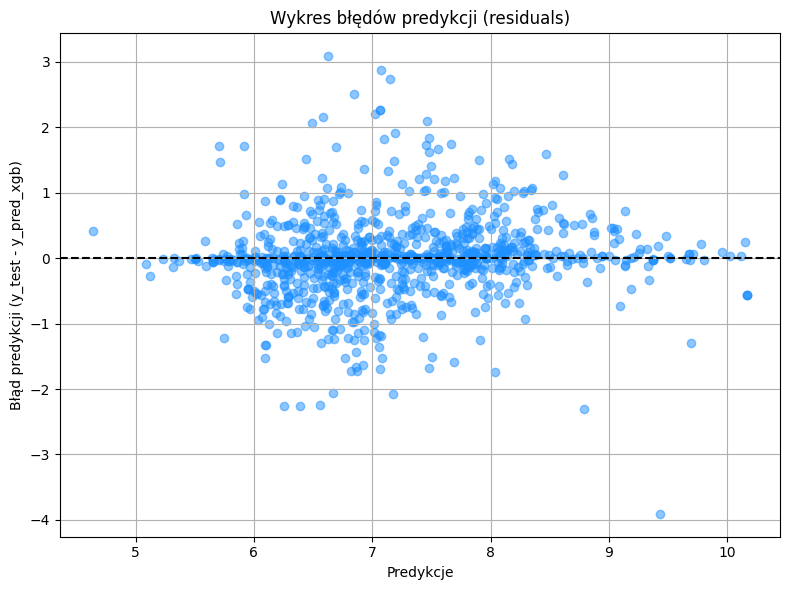

In [ ]:
residuals = y_test - y_pred_xgb

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_xgb, residuals, alpha=0.5, color='dodgerblue')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Predykcje')
plt.ylabel('B≈ÇƒÖd predykcji (y_test - y_pred_xgb)')
plt.title('Wykres b≈Çƒôd√≥w predykcji (residuals)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import xgboost as xgb

fig, ax = plt.subplots(figsize=(8, 6))
xgb.plot_importance(xgb_regr, importance_type='gain', max_num_features=15, height=0.5, ax=ax)
ax.grid(False)

for spine in ax.spines.values():
    spine.set_visible(False)

plt.title("Feature Importance ‚Äì XGBoost", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
import shap

# explainer = shap.Explainer(xgb_regr, X_test_transformed)
# shap_values = explainer(X_test[:100])

# shap.plots.beeswarm(shap_values)

sample_idx = np.random.choice(X_test_transformed.shape[0], size=500, replace=False)
X_sample = X_test_transformed.iloc[sample_idx]

explainer = shap.Explainer(xgb_regr, X_sample)
shap_values = explainer(X_sample)

# beeswarm z 30 najwa≈ºniejszymi cechami
shap.plots.beeswarm(shap_values, max_display=30)

100%|===================| 498/500 [03:14<00:00]       

In [ ]:
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
importance_df = pd.DataFrame({
    'feature': X_sample.columns,
    'mean_abs_shap': mean_abs_shap
}).sort_values(by='mean_abs_shap', ascending=False)

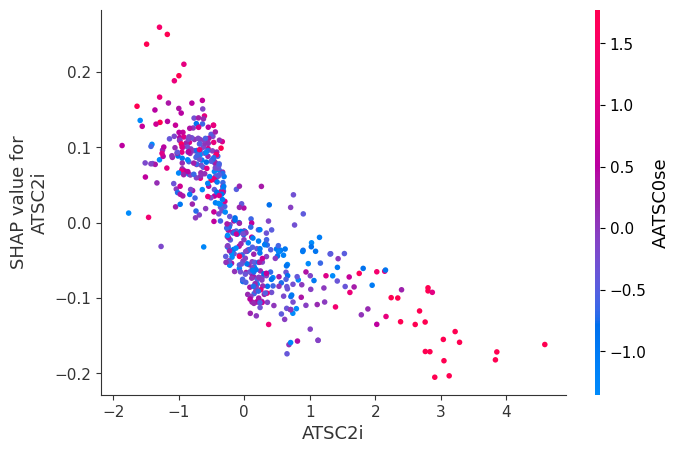

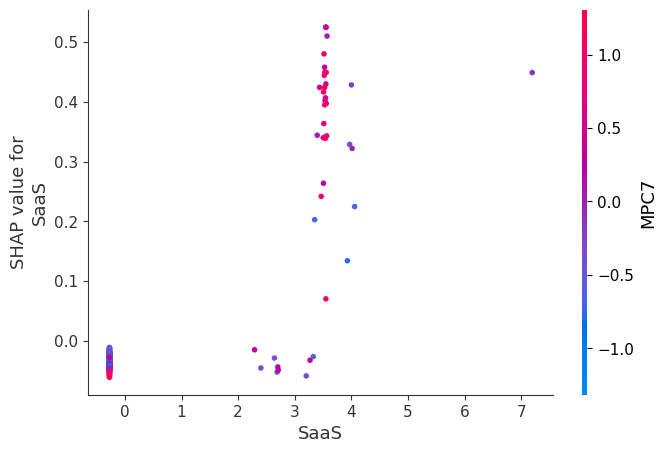

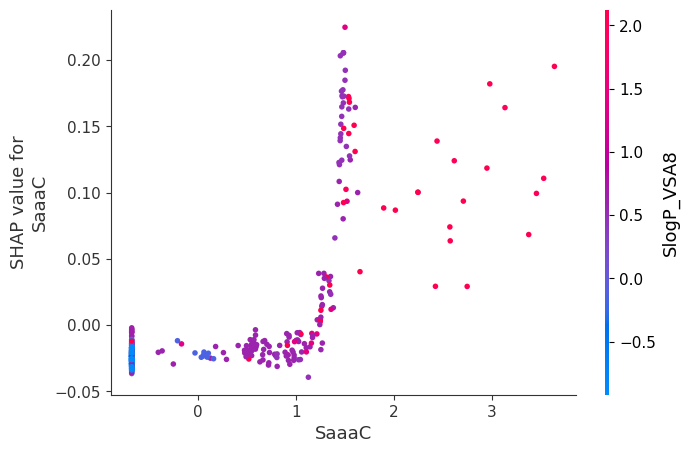

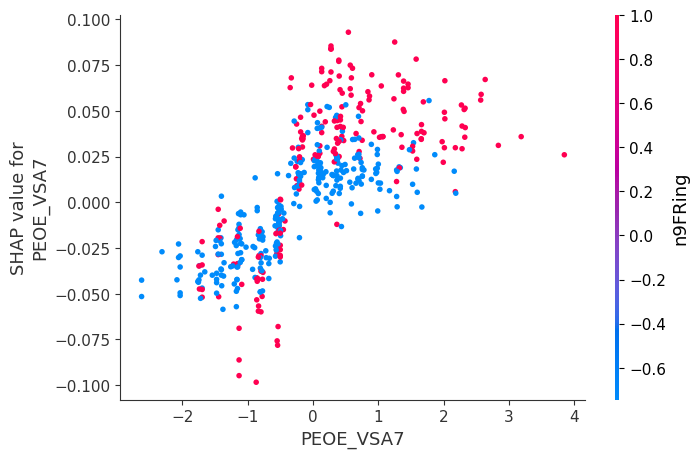

In [ ]:
top_features = importance_df.head(5)['feature'].values

for feat in top_features:
    shap.dependence_plot(feat, shap_values.values, X_sample)

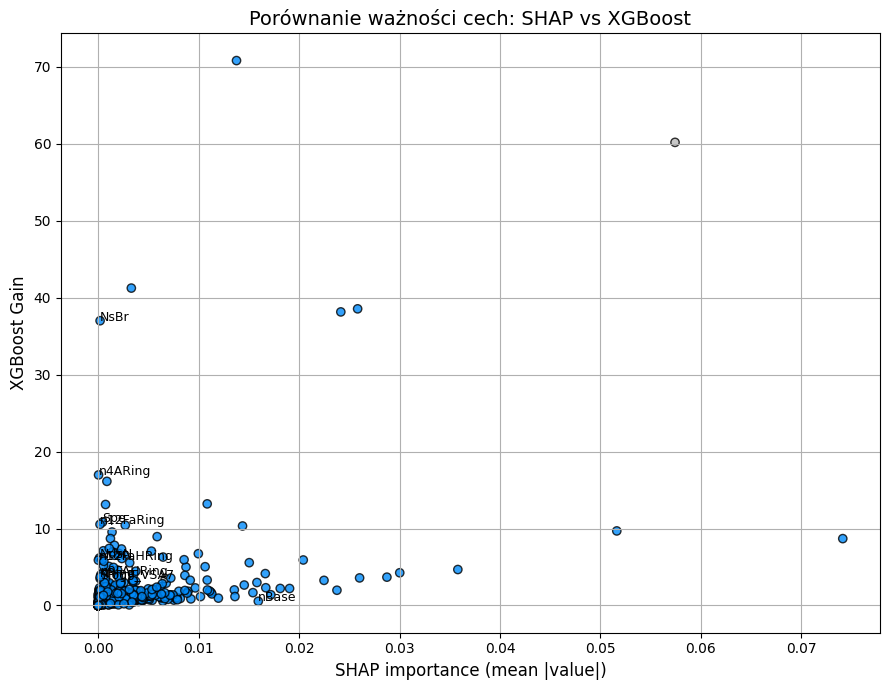

In [ ]:
# ma wysoki gain, ale niski SHAP ‚Üí jest czƒôsto u≈ºywana, ale nie ma du≈ºego wp≈Çywu na wynik,

# ma niski gain, ale wysoki SHAP ‚Üí dzia≈Ça tylko lokalnie lub silnie w interakcjach.

shap_df = pd.DataFrame({
    'feature': X.columns,
    'shap_importance': np.abs(shap_values.values).mean(axis=0)
}).sort_values('shap_importance', ascending=False)


booster = xgb_regr.get_booster()
gain_df = pd.DataFrame(
    booster.get_score(importance_type='gain').items(),
    columns=['feature', 'xgb_gain']
).sort_values('xgb_gain', ascending=False)

comparison_df = pd.merge(shap_df, gain_df, on='feature', how='outer').fillna(0)

comparison_df['shap_rank'] = comparison_df['shap_importance'].rank(ascending=False)
comparison_df['gain_rank'] = comparison_df['xgb_gain'].rank(ascending=False)
comparison_df['rank_diff'] = comparison_df['shap_rank'] - comparison_df['gain_rank']
comparison_df['abs_diff'] = comparison_df['rank_diff'].abs()

cmap = shap.plots.colors.red_blue
colors = comparison_df['rank_diff'].apply(
    lambda x: cmap(1 if x > 0 else 0) if x != 0 else '#BBBBBB'
)


plt.figure(figsize=(9,7))
plt.scatter(
    comparison_df['shap_importance'],
    comparison_df['xgb_gain'],
    c=colors,
    alpha=0.8,
    edgecolors='k'
)

plt.xlabel('SHAP importance (mean |value|)', fontsize=12)
plt.ylabel('XGBoost Gain', fontsize=12)
plt.title('Por√≥wnanie wa≈ºno≈õci cech: SHAP vs XGBoost', fontsize=14)
plt.grid(True)


for _, row in comparison_df.sort_values('abs_diff', ascending=False).head(10).iterrows():
    plt.text(row['shap_importance'], row['xgb_gain'], row['feature'], fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
# Najwiƒôksze r√≥≈ºnice ranking√≥w
comparison_df['abs_diff'] = comparison_df['rank_diff'].abs()
largest_discrepancy = comparison_df.sort_values('abs_diff', ascending=False).head(30)
print(largest_discrepancy[['feature', 'shap_rank', 'gain_rank', 'rank_diff']])

        feature  shap_rank  gain_rank  rank_diff
521     n4ARing     554.00       7.00     547.00
516  n12FaHRing     559.00      36.00     523.00
312        NsBr     512.00       6.00     506.00
517   n12FaRing     516.00      12.00     504.00
308        NdsN     530.00      31.00     499.00
572       nBase      18.00     485.00    -467.00
404         Spe     467.00      11.00     456.00
613       nRing     509.00      56.00     453.00
400  SlogP_VSA7     511.00      61.00     450.00
560   n9FAHRing     497.00      52.00     445.00
530    n5aHRing     475.00      33.00     442.00
495     Zagreb1     527.00      89.00     438.00
318        NsOH     541.00     106.00     435.00
588     nFARing     448.00      23.00     425.00
326      NssssC     537.00     116.00     421.00
81        ATS6Z      65.00     483.00    -418.00
569   nAromAtom     158.00     569.00    -411.00
387        SdsN     458.00      48.00     410.00
506  n10FaHRing     446.00      40.00     406.00
515    n12FRing     

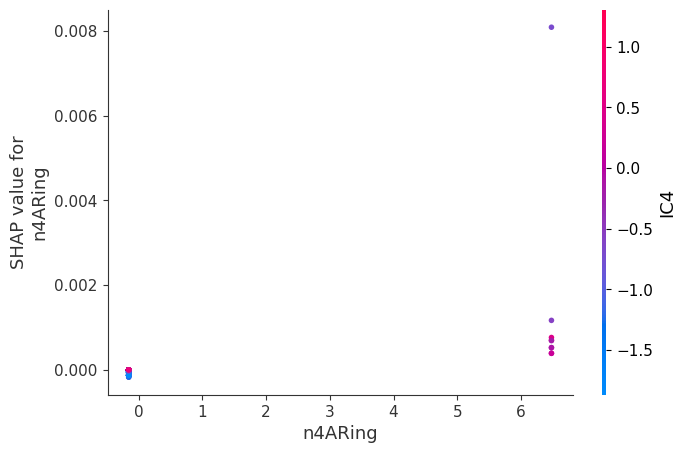

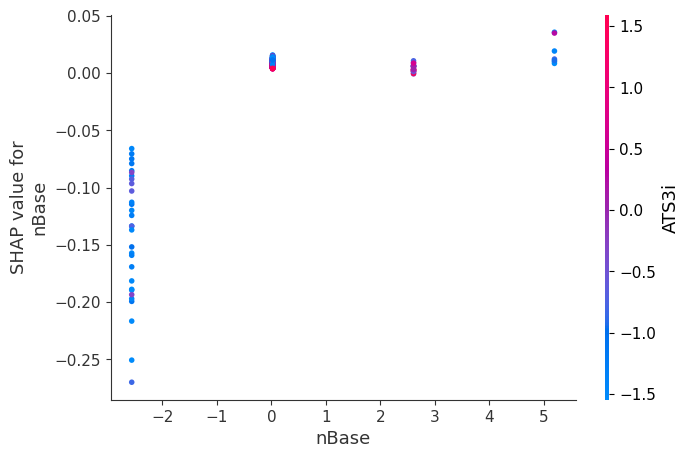

In [ ]:
features_tbc = ['n4ARing', 'nBase']

for feat in features_tbc:
    shap.dependence_plot(feat, shap_values.values, X_sample)

## REGRESJA - Final check na danych testowych

In [ ]:
test = pd.read_csv('test_data_no_pKi.csv')

# wczytanie deskryptorow dla smiles w zbiorze testowym
test_input = pd.merge(test, deskryptory, on='smiles', how='left')

# pozostawienie tylko deskryptorow uzytych w modelu
test_input_final = test_input[[col for col in num_cols if col in test_input.columns]]

# transformacja (standaryzacja)
test_input_final_transformed = pd.DataFrame(
    preprocessor.transform(test_input_final),
    columns=test_input_final.columns,
    index=test_input_final.index
)

In [ ]:
#loaded_model = joblib.load("xgboost_reg.pkl")
# predykcja na zbiorze
final_y_pred = xgb_regr.predict(test_input_final_transformed)

In [ ]:
results = pd.DataFrame({'ID': test['ID'], 'pKi': final_y_pred})
results.to_csv('results.csv', index=False)

## KLASYFIKACJA

### Przygotowanie etykiet

In [ ]:
data = raw_data_num.copy()

In [ ]:
data['reaction'] = data['PKI'].apply(lambda x: 1 if x > 7 else 0)

In [ ]:
profile_data(data)

üìä Profil danych:
‚û°Ô∏è Liczba wierszy: 4887
‚û°Ô∏è Liczba zmiennych: 633
üî¢ Liczba zmiennych numerycznych: 632
üî§ Liczba zmiennych tekstowych: 1
üî¢ Zmienne numeryczne (632): ['PKI', 'nAcid', 'nBase', 'nAromAtom', 'nAromBond', 'nAtom', 'nHeavyAtom', 'nSpiro', 'nBridgehead', 'nHetero', 'nH', 'nC', 'nN', 'nO', 'nS', 'nP', 'nF', 'nCl', 'nBr', 'nI', 'nX', 'ATS0dv', 'ATS1dv', 'ATS2dv', 'ATS3dv', 'ATS4dv', 'ATS5dv', 'ATS6dv', 'ATS7dv', 'ATS8dv', 'ATS0d', 'ATS1d', 'ATS2d', 'ATS3d', 'ATS4d', 'ATS5d', 'ATS6d', 'ATS7d', 'ATS8d', 'ATS0Z', 'ATS1Z', 'ATS2Z', 'ATS3Z', 'ATS4Z', 'ATS5Z', 'ATS6Z', 'ATS7Z', 'ATS8Z', 'ATS0m', 'ATS1m', 'ATS2m', 'ATS3m', 'ATS4m', 'ATS5m', 'ATS6m', 'ATS7m', 'ATS8m', 'ATS0v', 'ATS1v', 'ATS2v', 'ATS3v', 'ATS4v', 'ATS5v', 'ATS6v', 'ATS7v', 'ATS8v', 'ATS0se', 'ATS1se', 'ATS2se', 'ATS3se', 'ATS4se', 'ATS5se', 'ATS6se', 'ATS7se', 'ATS8se', 'ATS0pe', 'ATS1pe', 'ATS2pe', 'ATS3pe', 'ATS4pe', 'ATS5pe', 'ATS6pe', 'ATS7pe', 'ATS8pe', 'ATS0are', 'ATS1are', 'ATS2are', 'ATS3are',

dtype  missing_count  missing_percent  n_unique  \
PKI        float64              0             0.00      1731   
nAcid        int64              0             0.00         3   
nBase        int64              0             0.00         6   
nAromAtom    int64              0             0.00        24   
nAromBond    int64              0             0.00        22   
...            ...            ...              ...       ...   
Zagreb1    float64              0             0.00       105   
Zagreb2    float64              0             0.00       217   
mZagreb2   float64              0             0.00       971   
reaction     int64              0             0.00         2   
smiles      object              0             0.00      4887   

                                                   top_value  top_freq   mean  \
PKI                                                     6.00        46   7.18   
nAcid                                                   0.00      4743   0.03   
nBase                                                   1.00      4354   0.99   
nAromAtom                                              12.00      1386  12.82   
nAromBond                                              12.00      1370  13.24   
...                                                      ...       ...    ...   
Zagreb1                                               166.00       170 147.27   
Zagreb2                                               192.00       101 174.38   
mZagreb2                                                4.89        47   6.03   
reaction                                                1.00      2585   0.53   
smiles     Br.Cc1cccc(-c2c(O)c(O)cc3c2CCN(C)CC3c2cccc(C)c...         1    NaN   

            min    max    25%    50%    75%   std  
PKI        1.00  11.00   6.32   7.10   7.94  1.15  
nAcid      0.00   2.00   0.00   0.00   0.00  0.18  
nBase      0.00   5.00   1.00   1.00   1.00  0.39  
nAromAtom  0.00  30.00   9.00  12.00  16.00  4.42  
nAromBond  0.00  30.00  10.00  12.00  17.00  4.69  
...         ...    ...    ...    ...    ...   ...  
Zagreb1   38.00 362.00 122.00 154.00 174.00 36.55  
Zagreb2   40.00 445.00 145.00 182.00 205.00 43.97  
mZagreb2   2.21  15.78   4.97   6.26   7.06  1.45  
reaction   0.00   1.00   0.00   1.00   1.00  0.50  
smiles      NaN    NaN    NaN    NaN    NaN   NaN  

[633 rows x 13 columns]

### Przygotowanie danych do modelu

In [ ]:
# przygotowanie danych do modelu

y_class = data['reaction']
X_class = data.drop(columns=['PKI', 'smiles', 'reaction'])

# Podzia≈Ç
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
        X_class,
        y_class,
        test_size=0.2,
        random_state=42,
        stratify=y_class)


# Pipeline dla danych numerycznych
preprocessor_class = StandardScaler()

X_train_transformed_class = pd.DataFrame(
    preprocessor_class.fit_transform(X_train_class),
    columns=X_train_class.columns,
    index=X_train_class.index
)

X_test_transformed_class = pd.DataFrame(
    preprocessor_class.transform(X_test_class),
    columns=X_test_class.columns,
    index=X_test_class.index
)

In [ ]:
# zapis do pliku
joblib.dump(preprocessor_class, "preprocessor_scaler_class.pkl")

['preprocessor_scaler_class.pkl']

### Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

In [ ]:
def print_clf_feature_importance(model, X, name):
  # Warto≈õci wa≈ºno≈õci
  importances = model.feature_importances_
  features = X.columns if hasattr(X, 'columns') else [f'feature_{i}' for i in range(len(importances))]

  # DataFrame z wa≈ºno≈õciƒÖ
  importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
  }).sort_values(by='importance', ascending=False)
  # üî• Top 15
  top_features = importance_df.head(15)
  # Wykres
  plt.figure(figsize=(10, 6))
  plt.barh(top_features['feature'], top_features['importance'])
  plt.title(f"Feature importance {name}")
  plt.xlabel("Importance")
  plt.gca().invert_yaxis()
  plt.tight_layout()
  plt.show()

In [ ]:
def print_confusion_matrix(model, X, y_test, name):

  from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

  # predykcje
  y_pred_class = model.predict(X)

  # Macierz
  cm = confusion_matrix(y_test, y_pred_class)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(cmap="Blues")
  plt.title(f"Confusion Matrix {name}")
  plt.show()

In [ ]:
def print_classification_report(model, X, y_test, name):
    from sklearn.metrics import classification_report
    import pandas as pd
    import matplotlib.pyplot as plt

    y_pred = model.predict(X)
    report = classification_report(y_test, y_pred, output_dict=True)

    print(classification_report(y_test, y_pred))
    """
    report_df = pd.DataFrame(report).transpose()

    # Filtrujemy klasy (0, 1, ...) i ich metryki
    class_metrics = report_df.iloc[:-3][['precision', 'recall', 'f1-score']]

    # Rysujemy
    class_metrics.plot(kind='bar', figsize=(8, 5))
    plt.title(f"Precision, Recall, F1-score by class ‚Äì {name}")
    plt.ylabel("Score")
    plt.ylim(0, 1.1)
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
    """

In [ ]:
def print_roc_auc(model, X, y_test, name):
  from sklearn.metrics import roc_curve, auc
  plt.figure(figsize=(8,6))
  y_prob = model.predict_proba(X)[:,1]
  fpr, tpr, _ = roc_curve(y_test, y_prob)
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

  plt.plot([0,1], [0,1], 'k--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend()
  plt.grid()
  plt.show()

In [ ]:
# GXBOOST
xgb_clf = XGBClassifier(
    objective='binary:logistic',   # dla klasyfikacji binarnej
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=42
)

xgb_clf.fit(X_train_class, y_train_class)
y_pred_class = xgb_clf.predict(X_test_class)

In [ ]:
joblib.dump(xgb_clf, "xgboost_classifier.pkl")

['xgboost_classifier.pkl']

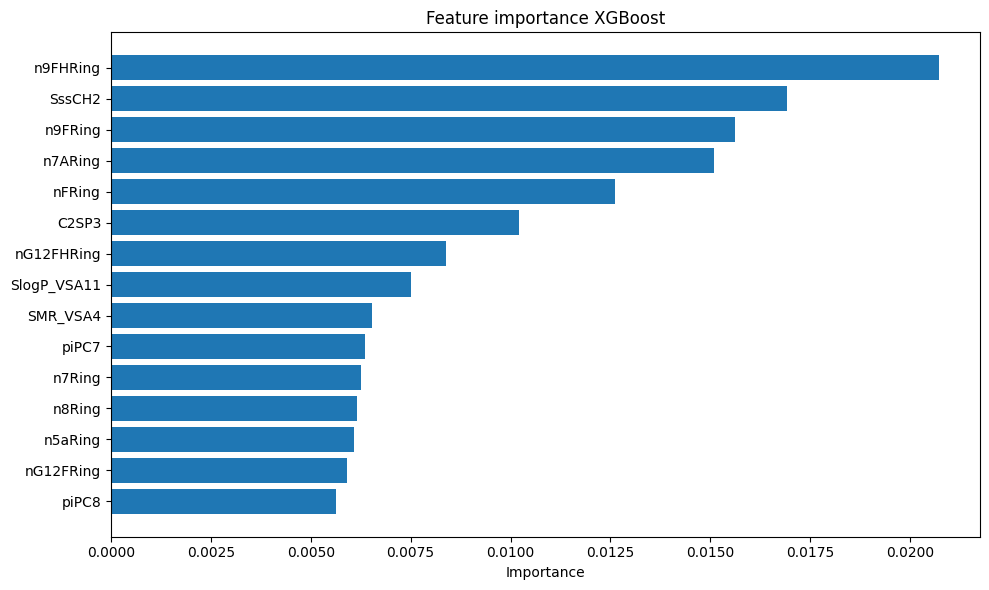

In [ ]:
print_clf_feature_importance(xgb_clf, X_train_class, "XGBoost")

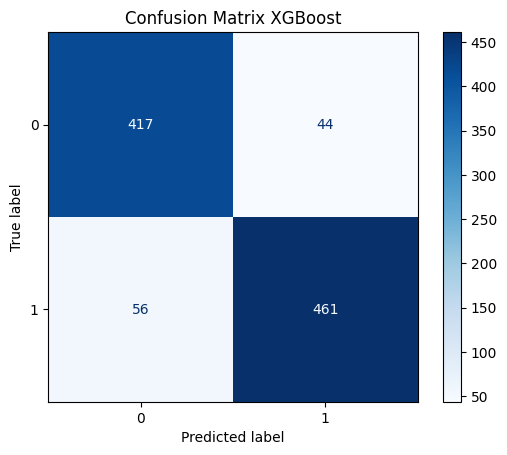

In [ ]:
print_confusion_matrix(xgb_clf, X_test_class, y_test_class, "XGBoost")

In [ ]:
print_classification_report(xgb_clf, X_test_class, y_test_class, "XGBoost")

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       461
           1       0.91      0.89      0.90       517

    accuracy                           0.90       978
   macro avg       0.90      0.90      0.90       978
weighted avg       0.90      0.90      0.90       978



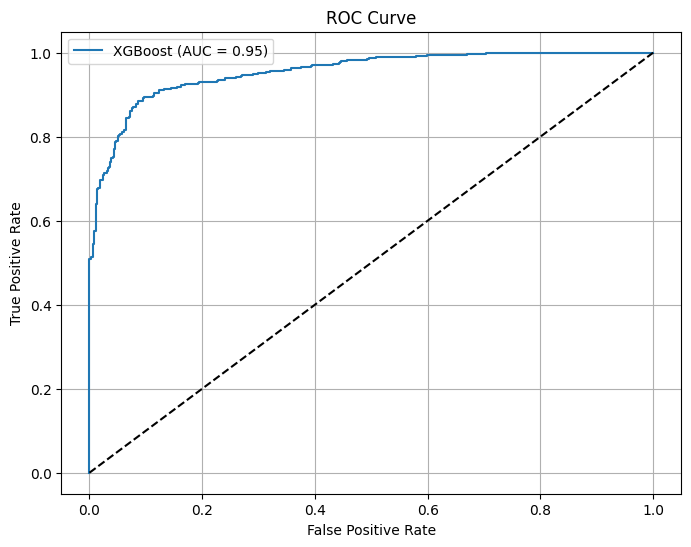

In [ ]:
print_roc_auc(xgb_clf, X_test_class, y_test_class, "XGBoost")

In [ ]:
# RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    n_estimators=100,     # liczba drzew
    max_depth=None,       # g≈Çƒôboko≈õƒá drzewa (None = bez limitu)
    random_state=42,      # dla powtarzalno≈õci wynik√≥w
    n_jobs=-1             # u≈ºyj wszystkich rdzeni CPU
)

rf_clf.fit(X_train_class, y_train_class)
y_pred_class_rf = rf_clf.predict(X_test_class)

In [ ]:
joblib.dump(rf_clf, "rf_classifier.pkl")

['rf_classifier.pkl']

In [ ]:
print_classification_report(rf_clf, X_test_class, y_test_class, "Random Forest")

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       461
           1       0.91      0.87      0.89       517

    accuracy                           0.89       978
   macro avg       0.89      0.89      0.89       978
weighted avg       0.89      0.89      0.89       978



In [ ]:
print_confusion_matrix(rf_clf, X_test_class, y_test_class, "Random Forest")

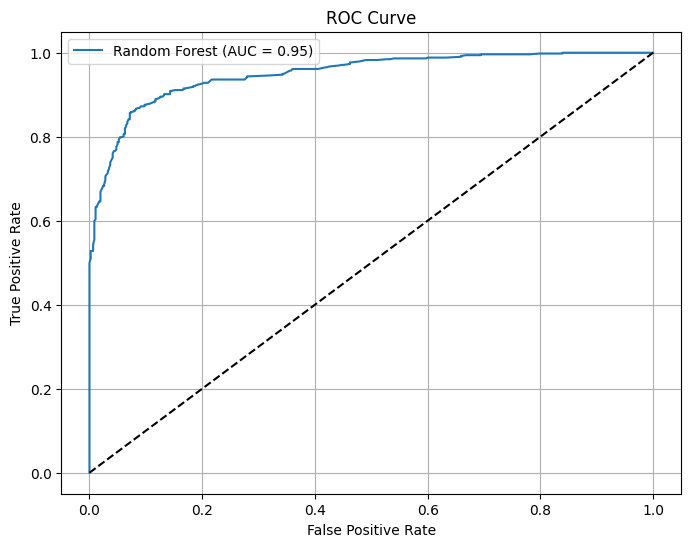

In [ ]:
print_roc_auc(rf_clf, X_test_class, y_test_class, "Random Forest")

### Analiza klasyfikatorow

In [ ]:
def compute_shap_values(model, X_test):
  sample_idx = np.random.choice(X_test.shape[0], size=500, replace=False)
  X_sample = X_test.iloc[sample_idx]

  explainer = shap.Explainer(model, X_sample)
  shap_values = explainer(X_sample)

  return shap_values, X_sample

In [ ]:
def plot_main_shap(shap_values, X_sample):
  if shap_values.values.ndim == 3:
    shap_values = shap_values[..., 1]  # bierzemy warto≈õci dla klasy 1
  # beeswarm z 30 najwa≈ºniejszymi cechami
  print("SHAP values dla 30  najwazniejszych cech")
  shap.plots.beeswarm(shap_values, max_display=30)

def print_top_shap(shap_values, X_sample):
  if shap_values.values.ndim == 3:
    shap_values = shap_values[..., 1]
  mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
  importance_df = pd.DataFrame({
    'feature': X_sample.columns,
    'mean_abs_shap': mean_abs_shap
  }).sort_values(by='mean_abs_shap', ascending=False)

  top_features = importance_df.head(5)['feature'].values
  for feat in top_features:
    shap.dependence_plot(feat, shap_values.values, X_sample)

def print_comparison_shap_feat_importance(shap_values, X_sample, model):
  # ma wysoki gain, ale niski SHAP ‚Üí jest czƒôsto u≈ºywana, ale nie ma du≈ºego wp≈Çywu na wynik,
  # ma niski gain, ale wysoki SHAP ‚Üí dzia≈Ça tylko lokalnie lub silnie w interakcjach.

  shap_df = pd.DataFrame({
      'feature': X.columns,
      'shap_importance': np.abs(shap_values.values).mean(axis=0)
  }).sort_values('shap_importance', ascending=False)


  booster = model.get_booster()
  gain_df = pd.DataFrame(
      booster.get_score(importance_type='gain').items(),
      columns=['feature', 'xgb_gain']
  ).sort_values('xgb_gain', ascending=False)

  comparison_df = pd.merge(shap_df, gain_df, on='feature', how='outer').fillna(0)
  comparison_df['shap_rank'] = comparison_df['shap_importance'].rank(ascending=False)
  comparison_df['gain_rank'] = comparison_df['xgb_gain'].rank(ascending=False)
  comparison_df['rank_diff'] = comparison_df['shap_rank'] - comparison_df['gain_rank']
  comparison_df['abs_diff'] = comparison_df['rank_diff'].abs()

  cmap = shap.plots.colors.red_blue
  colors = comparison_df['rank_diff'].apply(
      lambda x: cmap(1 if x > 0 else 0) if x != 0 else '#BBBBBB'
  )


  plt.figure(figsize=(9,7))
  plt.scatter(
      comparison_df['shap_importance'],
      comparison_df['xgb_gain'],
      c=colors,
      alpha=0.8,
      edgecolors='k'
  )

  plt.xlabel('SHAP importance (mean |value|)', fontsize=12)
  plt.ylabel('XGBoost Gain', fontsize=12)
  plt.title('Por√≥wnanie wa≈ºno≈õci cech: SHAP vs XGBoost', fontsize=14)
  plt.grid(True)


  for _, row in comparison_df.sort_values('abs_diff', ascending=False).head(10).iterrows():
    plt.text(row['shap_importance'], row['xgb_gain'], row['feature'], fontsize=9)

  plt.tight_layout()
  plt.show()


  # Najwiƒôksze r√≥≈ºnice ranking√≥w
  comparison_df['abs_diff'] = comparison_df['rank_diff'].abs()
  largest_discrepancy = comparison_df.sort_values('abs_diff', ascending=False).head(30)
  print(largest_discrepancy[['feature', 'shap_rank', 'gain_rank', 'rank_diff']])

In [ ]:
shap_xgb, sample_xgb = compute_shap_values(xgb_clf, X_test_class)

 99%|===================| 495/500 [01:56<00:01]       

In [ ]:
shap_rf, sample_rf = compute_shap_values(rf_clf, X_test_class)

 98%|===================| 977/1000 [00:39<00:00]       

In [ ]:
plot_main_shap(shap_xgb, sample_xgb)

SHAP values dla 30  najwazniejszych cech


In [ ]:
plot_main_shap(shap_rf, sample_rf)

SHAP values dla 30  najwazniejszych cech


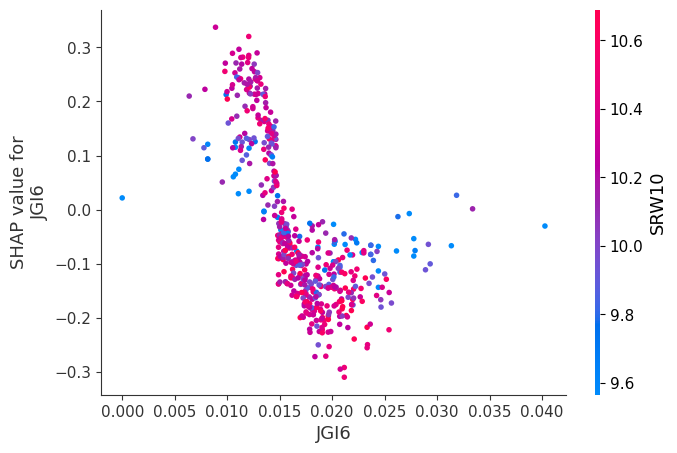

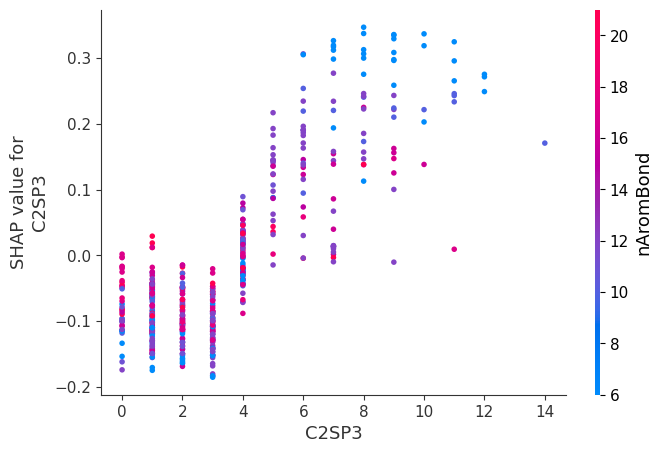

In [ ]:
print_top_shap(shap_xgb, sample_xgb)

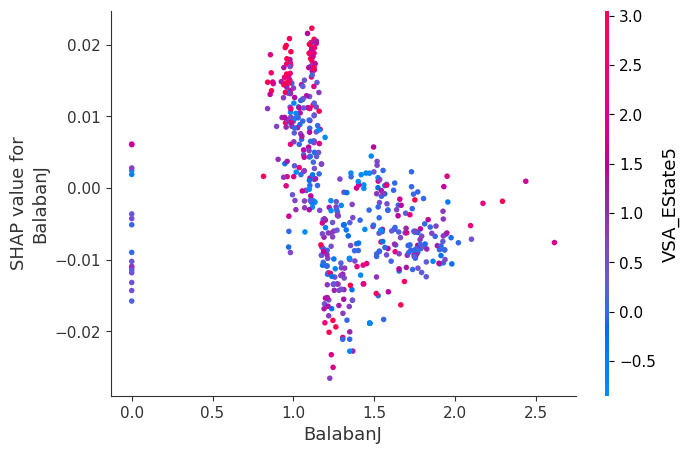

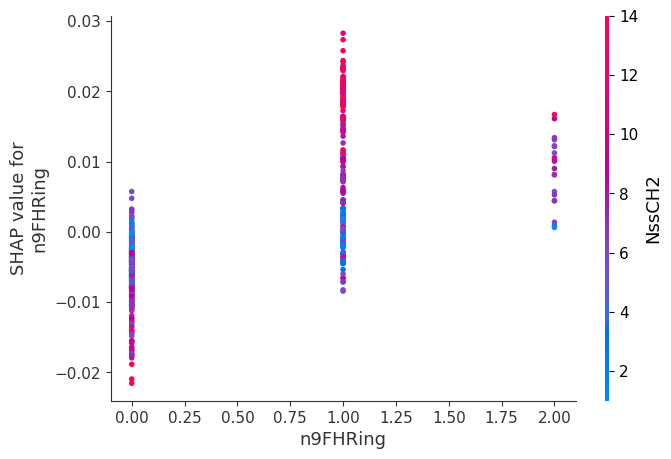

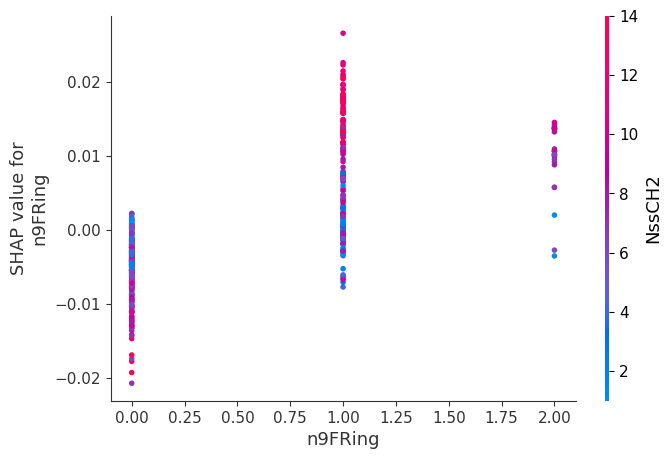

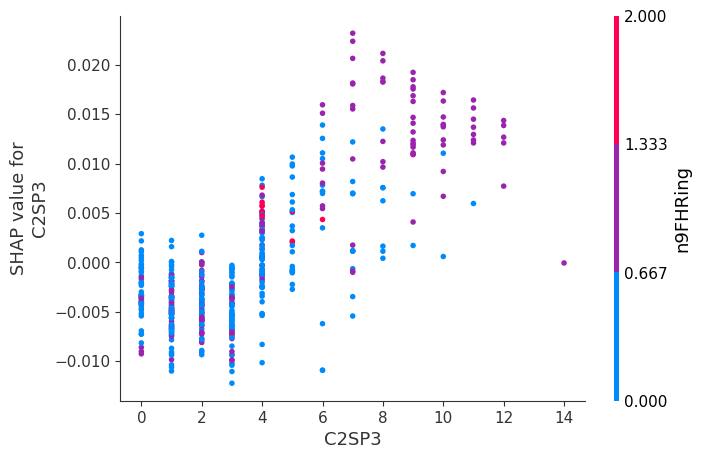

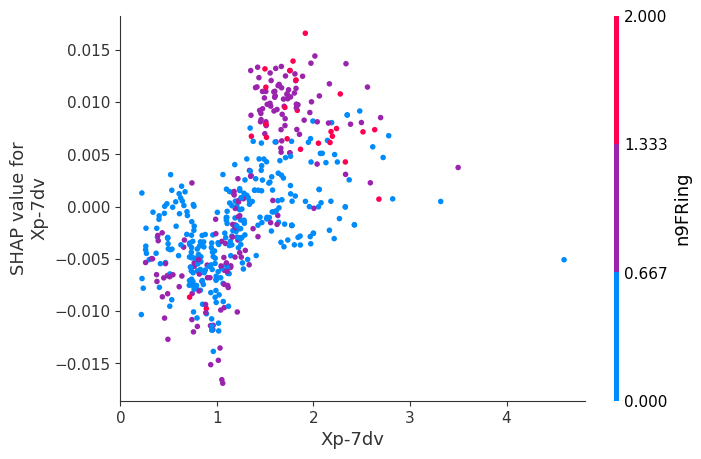

In [ ]:
print_top_shap(shap_rf, sample_rf)

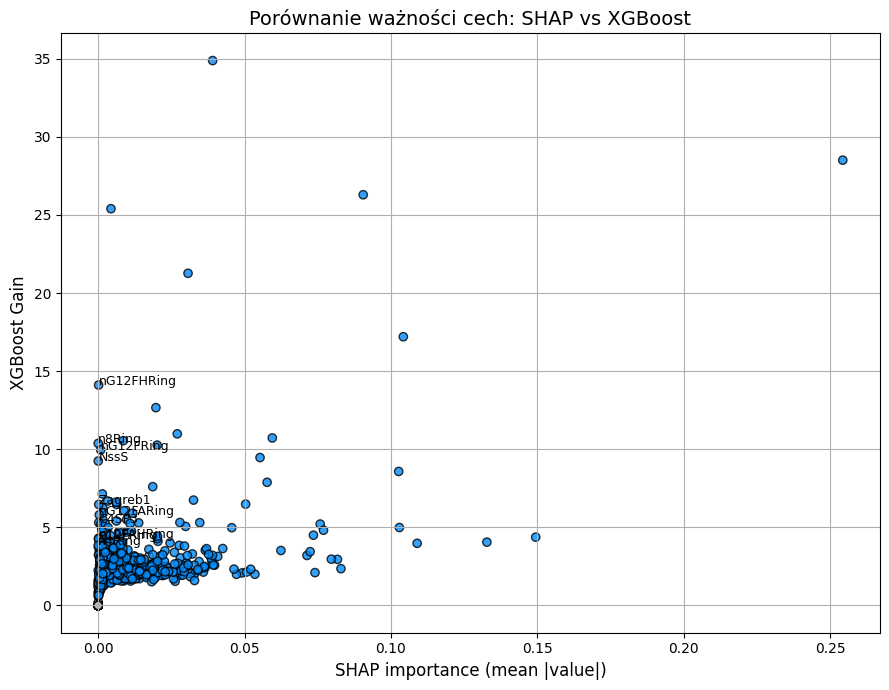

        feature  shap_rank  gain_rank  rank_diff
559      n8Ring     554.00      12.00     542.00
322        NssS     552.00      16.00     536.00
597  nG12FHRing     538.00       7.00     531.00
495     Zagreb1     531.00      25.00     506.00
211       C4SP3     533.00      36.00     497.00
596  nG12FARing     519.00      31.00     488.00
515    n12FRing     544.00      64.00     480.00
523      n4Ring     555.00      80.00     475.00
598   nG12FRing     482.00      14.00     468.00
502  n10FAHRing     528.00      61.00     467.00
507   n10FaRing     525.00      65.00     460.00
510   n11FHRing     540.00      83.00     457.00
195      ATSC8i      49.00     505.00    -456.00
453       Xc-4d     506.00      67.00     439.00
162    ATSC5are      77.00     513.00    -436.00
412         Sse     474.00      40.00     434.00
560   n9FAHRing     445.00      20.00     425.00
318        NsOH     466.00      43.00     423.00
511    n11FRing     542.00     120.00     422.00
450        WPol     

In [ ]:
print_comparison_shap_feat_importance(shap_xgb, sample_xgb, xgb_clf)

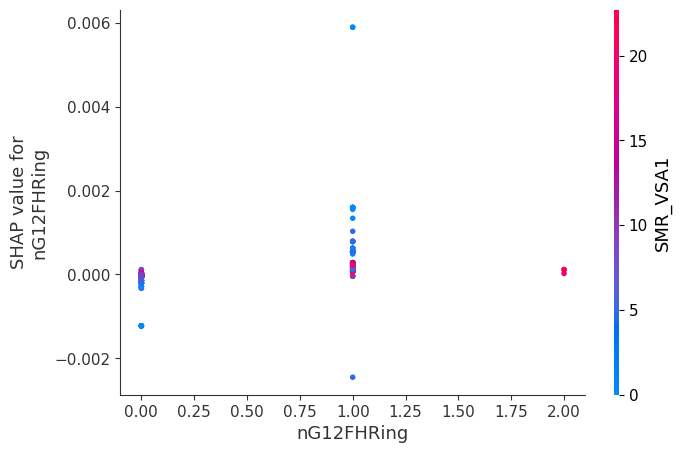

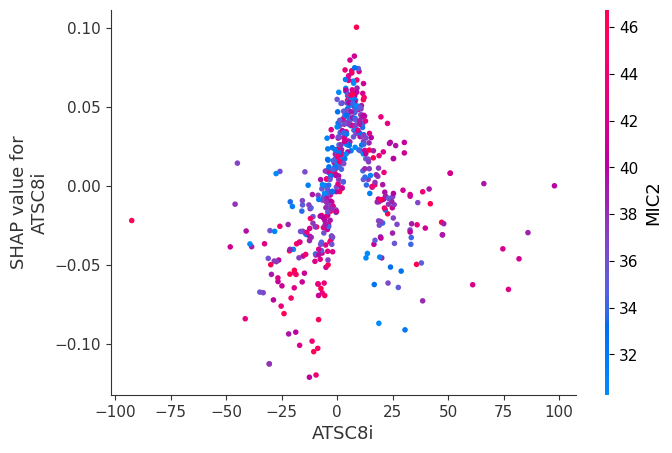

In [ ]:
features_tbc = ['nG12FHRing', 'ATSC8i']

for feat in features_tbc:
    shap.dependence_plot(feat, shap_xgb.values, sample_xgb)

# <b>Archiwum</b>

üåç **Lokalizacja:** D17 1.20

üë©‚Äçüíª **Informacje o hackathonie:**
- Nasi wsp√≥≈Çpracownicy z Wydzia≈Çu Farmaceutycznego UJ majƒÖ przygotowany bardzo ciekawy zbi√≥r danych opisujƒÖcy aktywacjƒô receptor√≥w w reakcji na r√≥≈ºne czƒÖsteczki.
- **Pa≈Ñstwa zadaniem bƒôdzie podjƒôcie siƒô predykcji tego, czy czƒÖstka aktywuje receptor w oparciu o jej w≈Çasno≈õci chemiczne.**
- Ca≈Ço≈õƒá ma formƒô konkursu zako≈Ñczonego  prezentacjƒÖ wynik√≥w osiƒÖgniƒôtych przez kilkuosobowe grupy.
- W ramach hackatonu stanƒÖ Pa≈Ñstwo przed zadaniem **wytrenowania modelu klasyfikacji bƒÖd≈∫ regresji** na zbiorze danych medycznych.
- Nie narzucamy narzƒôdzi, z kt√≥rych pomocƒÖ zadanie to ma zostaƒá wykonane. Przyk≈Çadowo mogƒÖ Pa≈Ñstwo w ramach grupy ustaliƒá, ≈ºe korzystacie z pythona, dane obrabiacie za pomocƒÖ bilioteki pandas i numpy, modele trenujecie w oparciu o scikit-learn, xgboost, pytorch etc, a raport/wizualizacje przygotowujecie w plotly.
- Do ustrukturyzowania wsp√≥≈Çpracy w grupie przyda siƒô znajomo≈õƒá systemu kontroli wersji git albo korzystanie z google collab.

**Przyk≈Çadowe datasety:**
- https://www.kaggle.com/datasets?search=solubility
- `from sklearn.datasets import make_classification`, nastƒôpnie `X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=42)`

**Link do draftu prezentacji:**
- https://docs.google.com/presentation/d/1jt7GbmdeuZoEze4hqkJGgNT4b8tSPsd_/edit?usp=sharing&ouid=115449660162134839913&rtpof=true&sd=true
- `do dostosowania wedle naszych potrzeb w niedzielƒô ;)`

## üéØ Wczytanie, EDA, przygotowanie danych (Sylwia)

In [ ]:
# niewykorzystane wizualizacje
def plot_categorical_bars(df, top_n=10):
    print("Top 10 zmiennych nienumerycznych.")
    cat_cols = df.select_dtypes(include=["object", "category", "string", "bool"]).columns

    if len(cat_cols) == 0:
        print("Brak zmiennych nienumerycznych.")
        return

    n = len(cat_cols)
    ncols = 2
    nrows = math.ceil(n / 2)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 4 * nrows))
    axes = axes.flatten()

    for i, col in enumerate(cat_cols):
        vc = df[col].value_counts().head(top_n)
        sns.barplot(x=vc.values, y=vc.index, ax=axes[i])
        axes[i].set_title(f"Top {top_n}: {col}")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])  # usu≈Ñ puste osie

    plt.tight_layout()
    plt.show()

def plot_scatter(df, x_col, y_col, hue=None, figsize=(8, 6), alpha=0.7):
    if x_col not in df.columns or y_col not in df.columns:
        raise ValueError("Podane kolumny muszƒÖ istnieƒá w DataFrame.")

    if not pd.api.types.is_numeric_dtype(df[x_col]) or not pd.api.types.is_numeric_dtype(df[y_col]):
        raise TypeError("Zar√≥wno x_col jak i y_col muszƒÖ byƒá typu numerycznego.")

    plt.figure(figsize=figsize)
    sns.scatterplot(data=df, x=x_col, y=y_col, hue=hue, alpha=alpha)
    plt.title(f"Scatter plot: {y_col} vs {x_col}")
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.tight_layout()
    plt.show()

def plot_numeric_by_category(df, numeric_col, category_col, plot_type="box", figsize=(10, 6), rotate_x=True):
    if numeric_col not in df.columns or category_col not in df.columns:
        raise ValueError("Podane kolumny muszƒÖ istnieƒá w DataFrame.")

    if not pd.api.types.is_numeric_dtype(df[numeric_col]):
        raise TypeError(f"Kolumna '{numeric_col}' musi byƒá typu numerycznego.")

    if pd.api.types.is_numeric_dtype(df[category_col]):
        print(f"‚ÑπÔ∏è Ostrze≈ºenie: '{category_col}' wyglƒÖda na numerycznƒÖ, ale u≈ºywana jako kategoryczna.")

    plt.figure(figsize=figsize)

    if plot_type == "box":
        sns.boxplot(data=df, x=category_col, y=numeric_col)
    elif plot_type == "violin":
        sns.violinplot(data=df, x=category_col, y=numeric_col, inner="quartile")
    elif plot_type == "strip":
        sns.stripplot(data=df, x=category_col, y=numeric_col, jitter=True, alpha=0.5)
    else:
        raise ValueError("plot_type musi byƒá jednym z: 'box', 'violin', 'strip'.")

    plt.title(f"{numeric_col} wg kategorii: {category_col}")
    if rotate_x:
        plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

def plot_grouped_countplot(
    df,
    category_col,
    hue_col,
    figsize=(10, 6),
    order=None,
    hue_order=None,
    palette="Set2",
    rotate_x=True
):
    plt.figure(figsize=figsize)
    sns.countplot(data=df, x=category_col, hue=hue_col, order=order, hue_order=hue_order, palette=palette)

    plt.title(f"Liczebno≈õƒá: {category_col} z podzia≈Çem na {hue_col}")
    plt.xlabel(category_col)
    plt.ylabel("Liczba obserwacji")

    if rotate_x:
        plt.xticks(rotation=45, ha="right")

    plt.tight_layout()
    plt.show()

def plot_stacked_bar(
    df,
    category_col,
    stack_col,
    normalize=False,
    figsize=(10, 6),
    colormap="Set2",
    rotate_x=True
):
    cross = pd.crosstab(df[category_col], df[stack_col])

    if normalize:
        cross = cross.div(cross.sum(axis=1), axis=0)

    cross.plot(kind="bar", stacked=True, figsize=figsize, colormap=colormap)

    plt.title(f"{'Proporcje' if normalize else 'Liczebno≈õƒá'}: {stack_col} w ramach {category_col}")
    plt.xlabel(category_col)
    plt.ylabel("Proporcja" if normalize else "Liczba obserwacji")

    if rotate_x:
        plt.xticks(rotation=45, ha="right")

    plt.legend(title=stack_col, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [ ]:
# Macierze korelacji
def plot_correlation_matrix(df, method="pearson", figsize=(10, 8), mask_upper=False, sort_by=None, threshold=None):
    print("Macierz korelacji zmiennych numerycznych")
    num_df = df.select_dtypes(include=["number"])

    if num_df.shape[1] < 2:
        print("Potrzeba co najmniej dw√≥ch zmiennych numerycznych do wyznaczenia korelacji.")
        return

    corr = num_df.corr(method=method)
    # Sortuj wed≈Çug korelacji z wybranƒÖ zmiennƒÖ
    if sort_by is not None and sort_by in corr.columns:
        sorted_cols = corr[sort_by].abs().sort_values(ascending=False).index
        corr = corr.loc[sorted_cols, sorted_cols]

    # Rozmiar figury dynamicznie zale≈ºny od liczby zmiennych
    n = len(corr.columns)
    figsize = (0.6 * n, 0.6 * n)

    mask = None
    # maskuje g√≥rny tr√≥jkƒÖt jesli wymagane
    if mask_upper:
        mask = np.triu(np.ones_like(corr, dtype=bool))

    # Zastosuj threshold: maskuj warto≈õci poni≈ºej progu
    if threshold is not None:
        threshold_mask = corr.abs() < threshold
        if mask is not None:
            mask = np.logical_or(mask, threshold_mask)
        else:
            mask = threshold_mask

    plt.figure(figsize=figsize)
    sns.heatmap(
        corr,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        mask=mask,
        vmin=-1,
        vmax=1,
        linewidths=0.5,
        square=True,
        cbar_kws={"shrink": 0.75}
    )
    title_extra = f", |corr| > {threshold}" if threshold else ""
    plt.title(f"Macierz korelacji ({method}){title_extra}", fontsize=14)
    plt.tight_layout()
    plt.show()

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1)) if n > 1 else 0
    r_corr = r - ((r-1)**2)/(n-1) if n > 1 else r
    k_corr = k - ((k-1)**2)/(n-1) if n > 1 else k
    denom = min((k_corr - 1), (r_corr - 1))
    return np.sqrt(phi2_corr / denom) if denom > 0 else np.nan

def plot_cramers_v_heatmap(
    df,
    categorical_columns=None,
    annot=True,
    cmap="YlOrBr",
    mask_upper=True,
    base_size=1.2,
    max_figsize=18
):
    # Wybierz kolumny kategoryczne
    if categorical_columns is None:
        categorical_columns = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

    if len(categorical_columns) < 2:
        print("Potrzeba co najmniej dw√≥ch zmiennych kategorycznych.")
        return

    # Oblicz macierz Cram√©r's V
    n = len(categorical_columns)
    result = pd.DataFrame(np.ones((n, n)), columns=categorical_columns, index=categorical_columns)

    for col1, col2 in combinations(categorical_columns, 2):
        v = cramers_v(df[col1], df[col2])
        result.loc[col1, col2] = v
        result.loc[col2, col1] = v

    # Maska g√≥rnego tr√≥jkƒÖta
    mask = None
    if mask_upper:
        mask = np.triu(np.ones_like(result, dtype=bool))

    # Dynamiczny rozmiar
    size = min(base_size * n, max_figsize)
    figsize = (size, size)

    # Rysuj heatmapƒô
    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        result,
        annot=annot,
        cmap=cmap,
        vmin=0,
        vmax=1,
        square=True,
        linewidths=0.5,
        mask=mask,
        cbar_kws={"shrink": 0.75}
    )

    # Etykiety
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
    plt.title("Cram√©r's V ‚Äì korelacje miƒôdzy zmiennymi kategorycznymi", fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
# Czyszczenie danych

def clean_missing_data(df, col_threshold=0.4, columns="all", verbose=True):
    df = df.copy()

    # Usu≈Ñ kolumny z nadmiarem brak√≥w
    col_nan_ratio = df.isnull().mean()
    cols_to_drop = col_nan_ratio[col_nan_ratio > col_threshold].index.tolist()
    df.drop(columns=cols_to_drop, inplace=True)

    if verbose and cols_to_drop:
        print(f"üìâ Usuniƒôto {len(cols_to_drop)} kolumn z brakami > {col_threshold*100:.0f}%: {cols_to_drop}\n")

    n_before = len(df)

    # Usu≈Ñ wiersze
    if columns == "all":
        df.dropna(inplace=True)
        method_desc = "wszystkich kolumnach"
    elif isinstance(columns, list):
        valid_cols = [col for col in columns if col in df.columns]
        if not valid_cols:
            if verbose:
                print("‚ö†Ô∏è ≈ªadna z podanych kolumn nie wystƒôpuje w DataFrame ‚Äî nic nie usuniƒôto.")
            return df
        df.dropna(subset=valid_cols, inplace=True)
        method_desc = f"istniejƒÖcych kolumnach: {valid_cols}"
    else:
        raise ValueError("Argument 'columns' musi byƒá 'all' lub listƒÖ kolumn.")

    n_after = len(df)

    if verbose:
        dropped = n_before - n_after
        print(f"üßπ Usuniƒôto {dropped} wierszy z brakami w {method_desc}")
        print(f"‚úÖ Pozosta≈Ço {n_after} wierszy i {df.shape[1]} kolumn.")

    return df


def fill_missing_values_by_column(df, value_dict, verbose=True):
    df = df.copy()

    for col, strategy in value_dict.items():
        if col not in df.columns:
            if verbose:
                print(f"‚ö†Ô∏è Kolumna '{col}' nie istnieje w DataFrame ‚Äî pominiƒôto.")
            continue

        n_missing = df[col].isna().sum()
        if n_missing == 0:
            if verbose:
                print(f"‚ÑπÔ∏è Kolumna '{col}' nie zawiera brak√≥w ‚Äî pominiƒôto.")
            continue

        if strategy == "mean":
            fill_val = df[col].mean()
        elif strategy == "median":
            fill_val = df[col].median()
        elif strategy == "mode":
            mode_series = df[col].mode()
            fill_val = mode_series.iloc[0] if not mode_series.empty else None
        else:
            fill_val = strategy  # sta≈Ça warto≈õƒá

        df[col].fillna(fill_val, inplace=True)

        if verbose:
            print(f"‚úÖ Wype≈Çniono {n_missing} brak√≥w w kolumnie '{col}' warto≈õciƒÖ: {fill_val}")

    return df

def drop_duplicates_verbose(df, subset=None, keep="first", verbose=True):
    df = df.copy()
    n_before = len(df)

    df.drop_duplicates(subset=subset, keep=keep, inplace=True)
    n_after = len(df)

    if verbose:
        dropped = n_before - n_after
        subset_info = f"w kolumnach {subset}" if subset else "we wszystkich kolumnach"
        print(f"üßπ Usuniƒôto {dropped} zduplikowanych wierszy ({subset_info}).")
        print(f"‚úÖ Pozosta≈Ço {n_after} wierszy.")

    return df

def convert_columns_by_type(df, type_to_columns_map, verbose=True, errors="raise"):
    df = df.copy()

    for target_type, cols in type_to_columns_map.items():
        valid_cols = [col for col in cols if col in df.columns]
        invalid_cols = [col for col in cols if col not in df.columns]

        for col in valid_cols:
            try:
                df[col] = df[col].astype(target_type, errors=errors)
                if verbose:
                    print(f"üîÅ Kolumna '{col}' przekonwertowana na typ {target_type}")
            except Exception as e:
                if errors == "raise":
                    raise e
                elif verbose:
                    print(f"‚ùå B≈ÇƒÖd przy konwersji '{col}' na {target_type}: {e}")

        if invalid_cols and verbose:
            print(f"‚ö†Ô∏è Pominiƒôto nieistniejƒÖce kolumny: {invalid_cols}")

    return df

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

In [ ]:
# Przygotowanie danych do modelu
# Zamiana na dane numeryczne lub boolowskie (kazdy model)
# Normalizacja
# Podzial na zbior testowy i treningowy (ten sam podzial, ten sam seed)

def prepare_pipeline_split(df, target, test_size=0.2, random_state=42, stratify=True, verbose=True):
    # Rozdzielenie X i y
    y = df[target]
    X = df.drop(columns=target)

    # Podzia≈Ç
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=random_state,
        stratify=y if stratify and y.nunique() < len(y) else None
    )

    # Identyfikacja kolumn
    numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
    categorical_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

    # Pipeline dla danych numerycznych
    numeric_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    # Pipeline dla danych kategorycznych
    categorical_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(drop="first", handle_unknown="ignore", sparse=False))
    ])

    # Po≈ÇƒÖczenie w ColumnTransformer
    preprocessor = ColumnTransformer([
        ("num", numeric_pipeline, numeric_cols),
        ("cat", categorical_pipeline, categorical_cols)
    ])

    # Fit tylko na danych treningowych
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)

    if verbose:
        print(f"üéØ Zmienna celu: {target}")
        print(f"üì¶ Kolumny numeryczne ({len(numeric_cols)}): {numeric_cols}")
        print(f"üì¶ Kolumny kategoryczne ({len(categorical_cols)}): {categorical_cols}")
        print(f"üîÑ Train shape: {X_train_transformed.shape}, Test shape: {X_test_transformed.shape}")

    return X_train_transformed, X_test_transformed, y_train, y_test, preprocessor

## üìà Regresja (Przemys≈Çaw)

In [ ]:
# Metryki SMALL transformed
print_regression_metrics(y_test, y_pred_regr, "LinearRegression")
print_regression_metrics(y_test, y_pred_ridge, "Ridge")
print_regression_metrics(y_test, y_pred_ridgeCV, "RidgeCV")
print_regression_metrics(y_test, y_pred_SGD, "SGDRegressor")
print_regression_metrics(y_test, y_pred_lasso, "Lasso")
print_regression_metrics(y_test, y_pred_lassoCV, "LassoCV")
print_regression_metrics(y_test, y_pred_elastic, "ElasticNet")
print_regression_metrics(y_test, y_pred_elasticCV, "ElasticNetCV")
print_regression_metrics(y_test, y_pred_huber, "HuberRegressor")
print_regression_metrics(y_test, y_pred_xgb, "XGBRegressor")

"""
Metryki dla LinearRegression:
  R2:    0.2956
  RMSE:  0.9762
  MAPE:  0.0932

Metryki dla Ridge:
  R2:    0.4552
  RMSE:  0.8586
  MAPE:  0.0900

Metryki dla RidgeCV:
  R2:    0.4377
  RMSE:  0.8723
  MAPE:  0.0899

Metryki dla SGDRegressor:
  R2:    -2599476720484617216.0000
  RMSE:  1875416308.2780
  MAPE:  185898181.3238

Metryki dla Lasso:
  R2:    -0.0005
  RMSE:  1.1635
  MAPE:  0.1356

Metryki dla LassoCV:
  R2:    0.4532
  RMSE:  0.8601
  MAPE:  0.0904

Metryki dla ElasticNet:
  R2:    -0.0005
  RMSE:  1.1635
  MAPE:  0.1356

Metryki dla ElasticNetCV:
  R2:    0.4520
  RMSE:  0.8610
  MAPE:  0.0905

Metryki dla HuberRegressor:
  R2:    0.3952
  RMSE:  0.9046
  MAPE:  0.0918

Metryki dla XGBRegressor:
  R2:    0.5598
  RMSE:  0.7718
  MAPE:  0.0839
  """

Metryki dla LinearRegression:
  R2:    0.2956
  RMSE:  0.9762
  MAPE:  0.0932

Metryki dla Ridge:
  R2:    0.4552
  RMSE:  0.8586
  MAPE:  0.0900

Metryki dla RidgeCV:
  R2:    0.4377
  RMSE:  0.8723
  MAPE:  0.0899

Metryki dla SGDRegressor:
  R2:    -2599476720484617216.0000
  RMSE:  1875416308.2780
  MAPE:  185898181.3238

Metryki dla Lasso:
  R2:    -0.0005
  RMSE:  1.1635
  MAPE:  0.1356

Metryki dla LassoCV:
  R2:    0.4532
  RMSE:  0.8601
  MAPE:  0.0904

Metryki dla ElasticNet:
  R2:    -0.0005
  RMSE:  1.1635
  MAPE:  0.1356

Metryki dla ElasticNetCV:
  R2:    0.4520
  RMSE:  0.8610
  MAPE:  0.0905

Metryki dla HuberRegressor:
  R2:    0.3952
  RMSE:  0.9046
  MAPE:  0.0918

Metryki dla XGBRegressor:
  R2:    0.5598
  RMSE:  0.7718
  MAPE:  0.0839



In [ ]:
# Metryki SMALL

print_regression_metrics(y_test, y_pred_regr, "LinearRegression")
print_regression_metrics(y_test, y_pred_ridge, "Ridge")
print_regression_metrics(y_test, y_pred_ridgeCV, "RidgeCV")
print_regression_metrics(y_test, y_pred_SGD, "SGDRegressor")
print_regression_metrics(y_test, y_pred_lasso, "Lasso")
print_regression_metrics(y_test, y_pred_lassoCV, "LassoCV")
print_regression_metrics(y_test, y_pred_elastic, "ElasticNet")
print_regression_metrics(y_test, y_pred_elasticCV, "ElasticNetCV")
print_regression_metrics(y_test, y_pred_huber, "HuberRegressor")
print_regression_metrics(y_test, y_pred_xgb, "XGBRegressor")

"""
Metryki dla LinearRegression:
  R2:    0.2956
  RMSE:  0.9762
  MAPE:  0.0932

Metryki dla Ridge:
  R2:    0.4295
  RMSE:  0.8786
  MAPE:  0.0890

Metryki dla RidgeCV:
  R2:    -371.1628
  RMSE:  22.4399
  MAPE:  1.1096

Metryki dla SGDRegressor:
  R2:    -118488962374765072816215672806758852263185219584.0000
  RMSE:  400399632456618493345792.0000
  MAPE:  11161195800075811422208.0000

Metryki dla Lasso:
  R2:    0.2068
  RMSE:  1.0359
  MAPE:  0.1150

Metryki dla LassoCV:
  R2:    0.0135
  RMSE:  1.1553
  MAPE:  0.1341

Metryki dla ElasticNet:
  R2:    0.2416
  RMSE:  1.0130
  MAPE:  0.1114

Metryki dla ElasticNetCV:
  R2:    0.0135
  RMSE:  1.1553
  MAPE:  0.1341

Metryki dla HuberRegressor:
  R2:    -0.3524
  RMSE:  1.3527
  MAPE:  0.1456

Metryki dla XGBRegressor:
  R2:    0.5598
  RMSE:  0.7718
  MAPE:  0.0839
  """

Metryki dla LinearRegression:
  R2:    0.2956
  RMSE:  0.9762
  MAPE:  0.0932

Metryki dla Ridge:
  R2:    0.4295
  RMSE:  0.8786
  MAPE:  0.0890

Metryki dla RidgeCV:
  R2:    -371.1628
  RMSE:  22.4399
  MAPE:  1.1096

Metryki dla SGDRegressor:
  R2:    -118488962374765072816215672806758852263185219584.0000
  RMSE:  400399632456618493345792.0000
  MAPE:  11161195800075811422208.0000

Metryki dla Lasso:
  R2:    0.2068
  RMSE:  1.0359
  MAPE:  0.1150

Metryki dla LassoCV:
  R2:    0.0135
  RMSE:  1.1553
  MAPE:  0.1341

Metryki dla ElasticNet:
  R2:    0.2416
  RMSE:  1.0130
  MAPE:  0.1114

Metryki dla ElasticNetCV:
  R2:    0.0135
  RMSE:  1.1553
  MAPE:  0.1341

Metryki dla HuberRegressor:
  R2:    -0.3524
  RMSE:  1.3527
  MAPE:  0.1456

Metryki dla XGBRegressor:
  R2:    0.5598
  RMSE:  0.7718
  MAPE:  0.0839



In [ ]:
# Metryki

print_regression_metrics(y_test, y_pred_regr, "LinearRegression")
print_regression_metrics(y_test, y_pred_ridge, "Ridge")
print_regression_metrics(y_test, y_pred_ridgeCV, "RidgeCV")
print_regression_metrics(y_test, y_pred_SGD, "SGDRegressor")
print_regression_metrics(y_test, y_pred_lasso, "Lasso")
print_regression_metrics(y_test, y_pred_lassoCV, "LassoCV")
print_regression_metrics(y_test, y_pred_elastic, "ElasticNet")
print_regression_metrics(y_test, y_pred_elasticCV, "ElasticNetCV")
print_regression_metrics(y_test, y_pred_huber, "HuberRegressor")
print_regression_metrics(y_test, y_pred_xgb, "XGBRegressor")

"""
Metryki dla LinearRegression:
  R2:    -4025.5590
  RMSE:  73.8111
  MAPE:  0.6941

Metryki dla Ridge:
  R2:    0.4636
  RMSE:  0.8519
  MAPE:  0.0889

Metryki dla RidgeCV:
  R2:    0.4581
  RMSE:  0.8563
  MAPE:  0.0897

Metryki dla SGDRegressor:
  R2:    -43119371151583505022976.0000
  RMSE:  241541039638.3260
  MAPE:  6793025713.3385

Metryki dla Lasso:
  R2:    -0.0005
  RMSE:  1.1635
  MAPE:  0.1356

Metryki dla LassoCV:
  R2:    0.4518
  RMSE:  0.8612
  MAPE:  0.0897

Metryki dla ElasticNet:
  R2:    -0.0005
  RMSE:  1.1635
  MAPE:  0.1356

Metryki dla ElasticNetCV:
  R2:    0.4539
  RMSE:  0.8596
  MAPE:  0.0897

Metryki dla HuberRegressor:
  R2:    0.4089
  RMSE:  0.8943
  MAPE:  0.0905

Metryki dla XGBRegressor:
  R2:    0.5716
  RMSE:  0.7613
  MAPE:  0.0827
  """

Metryki dla LinearRegression:
  R2:    -4025.5590
  RMSE:  73.8111
  MAPE:  0.6941

Metryki dla Ridge:
  R2:    0.4636
  RMSE:  0.8519
  MAPE:  0.0889

Metryki dla RidgeCV:
  R2:    0.4581
  RMSE:  0.8563
  MAPE:  0.0897

Metryki dla SGDRegressor:
  R2:    -43119371151583505022976.0000
  RMSE:  241541039638.3260
  MAPE:  6793025713.3385

Metryki dla Lasso:
  R2:    -0.0005
  RMSE:  1.1635
  MAPE:  0.1356

Metryki dla LassoCV:
  R2:    0.4518
  RMSE:  0.8612
  MAPE:  0.0897

Metryki dla ElasticNet:
  R2:    -0.0005
  RMSE:  1.1635
  MAPE:  0.1356

Metryki dla ElasticNetCV:
  R2:    0.4539
  RMSE:  0.8596
  MAPE:  0.0897

Metryki dla HuberRegressor:
  R2:    0.4089
  RMSE:  0.8943
  MAPE:  0.0905

Metryki dla XGBRegressor:
  R2:    0.5716
  RMSE:  0.7613
  MAPE:  0.0827



In [ ]:
# Wizualizacja
X_test_sorted = np.sort(X_test, axis=0)

plt.scatter(X_test, y_test, color='blue', edgecolor='black', alpha=0.5)

plt.plot(X_test_sorted, regr.predict(X_test_sorted), color='red', linewidth=0.6, label='Linear')
plt.plot(X_test_sorted, ridge.predict(X_test_sorted), color='green', linewidth=0.6, label='Ridge')
plt.plot(X_test_sorted, ridgeCV.predict(X_test_sorted), color='black', linewidth=0.6, label='RidgeCV')
plt.plot(X_test_sorted, SGDregr.predict(X_test_sorted), color='magenta', linewidth=0.6, label='SGDRegressor')
plt.plot(X_test_sorted, lasso.predict(X_test_sorted), color='orange', linewidth=0.6, label='Lasso')
plt.plot(X_test_sorted, lassoCV.predict(X_test_sorted), color='orange', linewidth=0.6, label='LassoCV')
plt.plot(X_test_sorted, elastic.predict(X_test_sorted), color='cyan', linewidth=0.6, label='ElasticNet')
plt.plot(X_test_sorted, elasticCV.predict(X_test_sorted), color='cyan', linewidth=0.6, label='ElasticNetCV')
plt.plot(X_test_sorted, huber.predict(X_test_sorted), color='brown', linewidth=0.6, label='HuberRegressor')
plt.plot(X_test_sorted, xgb_regr.predict(X_test_sorted), color='purple', linewidth=0.6, label='XGBRegressor')

plt.legend()
plt.title('Por√≥wnanie modeli - X_test')
plt.show()

In [ ]:
# Eliminacja wsteczna cech nieistotnych

import statsmodels.api as sm

X_train_ols = X_train.copy()
X_train_ols = X_train_ols.values
X_train_ols = sm.add_constant(X_train_ols)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
len(predictors)

338

In [ ]:
X_train_numpy = X_train.values
X_train_numpy = sm.add_constant(X_train_numpy)
num_vars = len(X_train_numpy[0])
predictors = ['const'] + list(X_train.columns)
sl = 0.05
for i in range(0, num_vars):
  ols = sm.OLS(endog=y_train, exog=X_train_numpy).fit()
  max_pval = max(ols.pvalues.astype('float'))
  if max_pval > sl:
    for j in range(0, num_vars - i):
      if ols.pvalues[j].astype('float') == max_pval:
        X_train_numpy = np.delete(X_train_numpy, j, axis=1)
        predictors.remove(predictors[j])
print(ols.summary(xname=predictors))

/tmp/ipython-input-160-327393133.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if ols.pvalues[j].astype('float') == max_pval:
/tmp/ipython-input-160-327393133.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if ols.pvalues[j].astype('float') == max_pval:
/tmp/ipython-input-160-327393133.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if ols.pvalues[j].astype('float') == max_pval:
/tmp/ipython-input-160-327393133.py:1

                                 OLS Regression Results                                
Dep. Variable:                    PKI   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                              1300.
Date:                Sat, 21 Jun 2025   Prob (F-statistic):                        0.00
Time:                        10:41:07   Log-Likelihood:                         -4040.6
No. Observations:                3909   AIC:                                      8707.
Df Residuals:                    3596   BIC:                                  1.067e+04
Df Model:                         313                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

## üç™ Klasyfikacja (Bartek)

### Kt√≥ry model wybraƒá?
- Ma≈Çe i ≈õrednie zbiory danych, du≈ºa interpretowalno≈õƒá: `LR`, `DT`, `KNN`
- Wysoka dok≈Çadno≈õƒá, z≈Ço≈ºone zale≈ºno≈õci: `RF`, `XGB`, `SVM`
- Du≈ºe zbiory danych (modele zoptymalizowane): `XGB`, `LR`

### 1. Przeszukiwanie siatki (Grid Search)



- **Jak dzia≈Ça:** Definiujesz sko≈Ñczony zestaw warto≈õci dla ka≈ºdego hiperparametru, kt√≥ry chcesz zoptymalizowaƒá. Grid Search wypr√≥bowuje ka≈ºdƒÖ mo≈ºliwƒÖ kombinacjƒô tych warto≈õci. Dla ka≈ºdej kombinacji trenuje model i ocenia jego wydajno≈õƒá (np. za pomocƒÖ walidacji krzy≈ºowej). Na koniec wybiera kombinacjƒô, kt√≥ra da≈Ça najlepszy wynik.
- **Zalety:** Dok≈Çadne przeszukiwanie zdefiniowanej przestrzeni. Gwarantuje znalezienie najlepszej kombinacji w ramach podanej siatki.
- **Wady:** Bardzo kosztowne obliczeniowo, zw≈Çaszcza gdy masz wiele hiperparametr√≥w i/lub wiele warto≈õci dla ka≈ºdego z nich (liczba kombinacji ro≈õnie wyk≈Çadniczo). Mo≈ºe byƒá nieefektywne, je≈õli optymalne warto≈õci le≈ºƒÖ poza zdefiniowanƒÖ siatkƒÖ.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

# Przyk≈Çadowe dane
X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=42)

# Definicja modelu
model = RandomForestClassifier(random_state=42)

# Definicja siatki parametr√≥w do przeszukania
param_grid = {
    'n_estimators': [100, 200, 300],  # Liczba drzew
    'max_depth': [None, 10, 20],      # Maksymalna g≈Çƒôboko≈õƒá drzewa
    'min_samples_split': [2, 5],      # Minimalna liczba pr√≥bek do podzia≈Çu
}

# Inicjalizacja GridSearchCV
# cv=5 oznacza 5-krotnƒÖ walidacjƒô krzy≈ºowƒÖ
# scoring='accuracy' oznacza metrykƒô oceny (mo≈ºe byƒá te≈º 'f1', 'roc_auc' itp.)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Uruchomienie przeszukiwania siatki
grid_search.fit(X, y)

# Najlepsze znalezione parametry i wynik
print(f"Najlepsze parametry: {grid_search.best_params_}")
print(f"Najlepszy wynik (accuracy): {grid_search.best_score_:.4f}")

# Najlepszy model
best_model = grid_search.best_estimator_

### 2. Przeszukiwanie losowe (Random Search)


- **Jak dzia≈Ça:** Zamiast przeszukiwaƒá wszystkie kombinacje, Random Search losowo pr√≥bkuje okre≈õlonƒÖ liczbƒô kombinacji z zdefiniowanych zakres√≥w hiperparametr√≥w.
- **Zalety:** Znacznie szybsze ni≈º Grid Search, zw≈Çaszcza w wysokowymiarowych przestrzeniach parametr√≥w. Okazuje siƒô, ≈ºe czƒôsto znajduje r√≥wnie dobre (lub nawet lepsze) kombinacje ni≈º Grid Search w kr√≥tszym czasie, poniewa≈º jest bardziej prawdopodobne, ≈ºe trafi na "ciekawe" regiony w przestrzeni parametr√≥w.
- **Wady:** Nie gwarantuje znalezienia optymalnej kombinacji (poniewa≈º jest losowe), ale w praktyce jest bardzo efektywne.

In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
#from sklearn.datasets import make_classification
from scipy.stats import randint

# Przyk≈Çadowe dane
#X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=42)

# Definicja modelu
model = RandomForestRegressor(random_state=42)

# Definicja przestrzeni parametr√≥w do przeszukania (dystrybucje dla losowania)
# U≈ºywamy randint dla ca≈Çkowitych, a np. uniform dla zmiennoprzecinkowych
param_distributions = {
    'n_estimators': randint(50, 1000, 50),  # Liczba drzew od 50 do 300
    'max_depth': [None, 10, 20, 30, 40], # Mo≈ºemy nadal podaƒá listƒô konkretnych warto≈õci
    'min_samples_split': randint(2, 10),
}

# Inicjalizacja RandomizedSearchCV
# n_iter=50 oznacza, ≈ºe zostanie wypr√≥bowanych 50 losowych kombinacji
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions,
                                   n_iter=50, cv=5, scoring='accuracy', n_jobs=-1, verbose=1, random_state=42)

# Uruchomienie przeszukiwania
random_search.fit(X, y)

print(f"Najlepsze parametry: {random_search.best_params_}")
print(f"Najlepszy wynik (accuracy): {random_search.best_score_:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits


KeyboardInterrupt: 

### 3. Optymalizacja Bayesowska (Bayesian Optimization)

- **Jak dzia≈Ça:** W przeciwie≈Ñstwie do Grid i Random Search, optymalizacja Bayesowska buduje model probabilistyczny (tzw. "funkcjƒô zastƒôpczƒÖ" lub "surrogate model") mapujƒÖcy hiperparametry na wynik wydajno≈õci modelu. Nastƒôpnie u≈ºywa tego modelu do inteligentnego wybierania kolejnych kombinacji hiperparametr√≥w do przetestowania, starajƒÖc siƒô zr√≥wnowa≈ºyƒá eksploracjƒô (szukanie w nieznanych obszarach) i eksploatacjƒô (zag≈Çƒôbianie siƒô w obiecujƒÖce obszary).
- **Zalety:** Znacznie bardziej efektywna w znajdowaniu optymalnych hiperparametr√≥w, szczeg√≥lnie w wysokowymiarowych przestrzeniach i gdy ocena modelu jest kosztowna obliczeniowo. Potrzebuje mniej iteracji ni≈º Grid/Random Search.
- **Wady:** Z≈Ço≈ºono≈õƒá implementacji (choƒá sƒÖ dostƒôpne biblioteki). Mo≈ºe byƒá wra≈ºliwa na poczƒÖtkowe parametry.
- **Popularne biblioteki:** Hyperopt, Optuna, GPyOpt, scikit-optimize (skopt).

In [ ]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification

# Przyk≈Çadowe dane
X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=42)

# Definicja funkcji celu (objective function), kt√≥ra Optuna bƒôdzie minimalizowaƒá/maksymalizowaƒá
def objective(trial):
    # Sugestie Optuna dla hiperparametr√≥w
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )

    # Ocena modelu za pomocƒÖ walidacji krzy≈ºowej
    # Optuna domy≈õlnie minimalizuje, wiƒôc zwracamy ujemny wynik accuracy
    # (lub 1 - accuracy je≈õli chcemy minimalizowaƒá b≈ÇƒÖd)
    score = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()
    return score

# Utworzenie studium optymalizacji
# direction='maximize' oznacza, ≈ºe Optuna bƒôdzie pr√≥bowa≈Ça zmaksymalizowaƒá wynik funkcji celu
study = optuna.create_study(direction='maximize')

# Uruchomienie optymalizacji
# n_trials=50 oznacza liczbƒô pr√≥b (iteracji)
study.optimize(objective, n_trials=50)

print(f"Najlepsze parametry (Optuna): {study.best_params}")
print(f"Najlepszy wynik (accuracy, Optuna): {study.best_value:.4f}")

## üìä Wizualizacja wynikow (Katarzyna)

### ****Bonus - opcjonalnie****

**Definicja do analizy danych tak aby≈õmy mogli sprawnie sprawdziƒá jakie mamy dane i zdecydowaƒá o dalszym sposobie pracy oczywi≈õcie mo≈ºna rozbudowaƒá o inne parametry**

Obejmuje:

Braki danych ‚Äì liczba brak√≥w w ka≈ºdej kolumnie.

Duplikaty ‚Äì liczba zduplikowanych wierszy.

Unikalne warto≈õci ‚Äì liczba r√≥≈ºnych warto≈õci w ka≈ºdej kolumnie.

Korelacje ‚Äì macierz korelacji cech numerycznych (Pearson), z heatmapƒÖ.

Mutual Information ‚Äì zale≈ºno≈õƒá cech numerycznych od zmiennej celu (dla klasyfikacji lub regresji).

Outliery (IQR) ‚Äì liczba warto≈õci odstajƒÖcych w ka≈ºdej kolumnie numerycznej.

Normalno≈õƒá rozk≈Çadu ‚Äì test Shapiro-Wilka dla cech numerycznych (czy rozk≈Çad ‚âà normalny).

Wizualizacja brak√≥w danych ‚Äì wykres s≈Çupkowy z procentem brak√≥w.

Sugestie preprocessingowe ‚Äì zalecenia dot. usuwania duplikat√≥w, outlier√≥w, transformacji itp.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import RidgeCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_curve
import missingno as msno
from sklearn.tree import DecisionTreeClassifier

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from scipy.stats import shapiro

def detect_data_issues(df, target=None, problem_type='classification'):
    report = {}

    # Dane numeryczne
    num_df = df.select_dtypes(include=[np.number])

    # Braki danych
    missing = df.isnull().sum()
    report['missing'] = missing[missing > 0]

    # Duplikaty
    report['duplicates'] = df.duplicated().sum()

    # Unikalne warto≈õci
    unique_vals = df.nunique()
    report['unique_values'] = unique_vals

    # Korelacje (tylko numeryczne kolumny)
    corr = num_df.corr()
    report['correlation'] = corr

    # Heatmapa korelacji
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
    plt.title('Heatmapa korelacji cech numerycznych')
    plt.tight_layout()
    plt.show()

    # Mutual Information (tylko je≈õli target podany)
    if target is not None:
        X = df.drop(columns=[target])
        y = df[target]
        if problem_type == 'classification':
            mi = mutual_info_classif(X.select_dtypes(include=[np.number]), y, discrete_features='auto')
        else:
            mi = mutual_info_regression(X.select_dtypes(include=[np.number]), y)
        mi_series = pd.Series(mi, index=X.select_dtypes(include=[np.number]).columns)
        report['mutual_info'] = mi_series.sort_values(ascending=False)

    # Detekcja outlier√≥w (IQR) - dla numerycznych kolumn
    outliers = {}
    for col in num_df.columns:
        Q1 = num_df[col].quantile(0.25)
        Q3 = num_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_count = num_df[(num_df[col] < lower_bound) | (num_df[col] > upper_bound)].shape[0]
        outliers[col] = outlier_count
    report['outliers'] = outliers

    # Test normalno≈õci Shapiro-Wilka (dla numerycznych kolumn)
    normality = {}
    for col in num_df.columns:
        if num_df[col].nunique() > 3:
            try:
                stat, p_value = shapiro(num_df[col].dropna().sample(n=min(5000, len(num_df)), random_state=42))
                normality[col] = {'statistic': stat, 'p_value': p_value, 'normal': p_value > 0.05}
            except:
                normality[col] = {'statistic': None, 'p_value': None, 'normal': None}
        else:
            normality[col] = {'statistic': None, 'p_value': None, 'normal': None}
    report['normality'] = normality

    # Histogram brak√≥w
    missing_percent = df.isnull().mean() * 100
    missing_percent = missing_percent[missing_percent > 0]
    if not missing_percent.empty:
        plt.figure(figsize=(8, 4))
        missing_percent.plot(kind='bar', color='orange')
        plt.ylabel('% brakujƒÖcych danych')
        plt.title('Procent brak√≥w danych w kolumnach')
        plt.tight_layout()
        plt.show()

    # Sugestie preprocessingowe
    preprocessing_suggestions = []

    if report['duplicates'] > 0:
        preprocessing_suggestions.append("Usu≈Ñ duplikaty danych.")

    if len(report['missing']) > 0:
        preprocessing_suggestions.append("Uzupe≈Çnij lub usu≈Ñ brakujƒÖce dane.")

    for col, out_num in outliers.items():
        if out_num > 0:
            preprocessing_suggestions.append(f"Zbadaj i ewentualnie usu≈Ñ lub przekszta≈Çƒá outliery w kolumnie {col}.")

    for col, norm_test in normality.items():
        if norm_test['normal'] is False:
            preprocessing_suggestions.append(f"Rozwa≈º transformacjƒô kolumny {col} (np. log, sqrt) ze wzglƒôdu na brak normalno≈õci.")

    if target is not None and 'mutual_info' in report:
        low_mi = report['mutual_info'][report['mutual_info'] < 0.01]
        if not low_mi.empty:
            preprocessing_suggestions.append("Niekt√≥re cechy majƒÖ bardzo niskƒÖ informacjƒô wzajemnƒÖ z celem i mogƒÖ nie byƒá istotne.")

    report['preprocessing_suggestions'] = preprocessing_suggestions

    # Raport tekstowy
    print("\n=== RAPORT PROBLEM√ìW Z DANYMI ===")
    print(f"Duplikaty: {report['duplicates']}")
    print("\nBraki danych (liczba):")
    print(report['missing'])
    print("\nOutliery (liczba w kolumnie):")
    print(outliers)
    print("\nTest normalno≈õci (Shapiro-Wilk, p > 0.05 oznacza normalny rozk≈Çad):")
    for col, test in normality.items():
        if test['p_value'] is not None:
            print(f" - {col}: p={test['p_value']:.4f}, normalny={test['normal']}")
    if target is not None and 'mutual_info' in report:
        print("\nInformacja wzajemna cech wzglƒôdem celu:")
        print(report['mutual_info'])

    print("\nSugestie preprocessingowe:")
    for s in preprocessing_suggestions:
        print(" -", s)

    return report

In [ ]:
#   # wczytaj dataset do df
report = detect_data_issues(df, target="Solubility", problem_type='regression')  # ‚Üê podaj nazwƒô kolumny celu TARGET

# report = detect_data_issues(df, target='target_column_name', problem_type='classification')
# problem_type='classification'  # domy≈õlnie
# problem_type='regression'      # je≈õli to problem regresji

# Wy≈õwietl raport
for section, content in report.items():
    print(f"\n==== {section} ====")
    print(content)

### ****WIZUALIZACJE DLA MODELI REGRESYJNYCH****

**Cel**: zobaczyƒá jak dobrze model przewiduje warto≈õci ciƒÖg≈Çe.

In [ ]:
!pip install scikit-learn matplotlib seaborn pandas --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, precision_recall_curve,
    accuracy_score, precision_score, recall_score, f1_score
)

# Styl wykres√≥w
sns.set(style='whitegrid', palette='muted', font_scale=1.1)

In [ ]:
# Modele regresyjne do por√≥wnania w li≈õcie * mo≈ºna inaczej
models = {
    'Linear': LinearRegression(),
    'Tree': DecisionTreeRegressor(random_state=42),
    'Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# S≈Çownik na predykcje
preds = {}

### 1. **Predykcje vs warto≈õci rzeczywiste**

- wykres rozrzutu `y_true` vs `y_pred`
- dobra praktyka: narysuj **liniƒô idealnƒÖ y=x**
- pokazuje jak bardzo model siƒô rozje≈ºd≈ºa

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for i, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    preds[name] = y_pred

    axs[i].scatter(y_test, y_pred, alpha=0.5, label='Predykcje')
    axs[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Idealna')
    axs[i].set_title(f'{name} - y_true vs y_pred')
    axs[i].set_xlabel('Rzeczywiste')
    axs[i].set_ylabel('Przewidziane')
    axs[i].legend()

plt.tight_layout()
plt.show()

# üîé Interpretacja: Im bli≈ºej czerwonej linii, tym lepiej. Rozrzut = b≈ÇƒÖd modelu.

### 2. **Residual Plot (b≈Çƒôdy)**

- o≈õ X: warto≈õci przewidziane
- o≈õ Y: r√≥≈ºnica (b≈ÇƒÖd) `y_true - y_pred`
- dobry model ma reszty losowe, bez wzoru

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for i, (name, y_pred) in enumerate(preds.items()):
    residuals = y_test - y_pred
    axs[i].scatter(y_pred, residuals, alpha=0.5)
    axs[i].axhline(0, color='red', linestyle='--')
    axs[i].set_title(f'{name} - Residuals')
    axs[i].set_xlabel('y_pred')
    axs[i].set_ylabel('B≈ÇƒÖd (y_true - y_pred)')

plt.tight_layout()
plt.show()

# üîé Dobry model ma losowe reszty wok√≥≈Ç zera ‚Äì bez wzoru czy systematycznych odchyle≈Ñ.

### 3. **Histogram b≈Çƒôd√≥w (reszt)**

- pokazuje czy model systematycznie siƒô myli w jednƒÖ stronƒô

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for i, (name, y_pred) in enumerate(preds.items()):
    residuals = y_test - y_pred
    axs[i].hist(residuals, bins=30, alpha=0.7)
    axs[i].set_title(f'{name} - Histogram reszt')
    axs[i].set_xlabel('B≈ÇƒÖd')
    axs[i].set_ylabel('Czƒôsto≈õƒá')

plt.tight_layout()
plt.show()

# üîé Je≈õli histogram jest symetryczny wok√≥≈Ç zera ‚Äì dobrze.
# Je≈õli przesuniƒôty ‚Äì model systematycznie zawy≈ºa lub zani≈ºa.

### 4. **Tabela por√≥wnawcza metryk**

- MAE, MSE, RMSE, R¬≤ dla ka≈ºdego modelu
- najlepiej jako ma≈Ça tabelka obok wykres√≥w

In [ ]:
results = []

for name, y_pred in preds.items():
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results.append([name, mae, mse, rmse, r2])

df_results = pd.DataFrame(results, columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2'])
print(df_results)

# üîé R2 blisko 1 = dobry model. RMSE powinno byƒá jak najni≈ºsze.

### ****WIZUALIZACJE DLA MODELI KLASYFIKACYJNYCH****


**Cel**: pokazaƒá jak dobrze model rozpoznaje klasy

In [ ]:
# Modele regresyjne do por√≥wnania w li≈õcie * mo≈ºna inaczej
models_cls = {
    'Logistic': LogisticRegression(max_iter=1000),
    'Tree': DecisionTreeClassifier(random_state=42),
    'Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# S≈Çownik na predykcje
preds_cls = {}

### 1. **Macierz pomy≈Çek (confusion matrix)**

- wizualna tabela: ile przyk≈Çad√≥w poprawnie/≈∫le zaklasyfikowano
- najlepiej w formie heatmapy

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for i, (name, model) in enumerate(models_cls.items()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    preds_cls[name] = y_pred

    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=data.target_names)
    disp.plot(ax=axs[i], cmap='Blues', colorbar=False)
    axs[i].set_title(f'{name}')

plt.tight_layout()
plt.show()

# üîé Dobrze, je≈õli wiƒôkszo≈õƒá predykcji trafia w przekƒÖtnƒÖ (TP i TN).

### 2. **Krzywa ROC / AUC**

- dla klasyfikacji binarnej ‚Äì pokazuje czu≈Ço≈õƒá vs specyficzno≈õƒá
- dobra, gdy chcesz por√≥wnaƒá 2‚Äì3 modele

In [ ]:
plt.figure(figsize=(8,6))
for name, model in models_cls.items():
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:,1]
    probs_cls[name] = y_prob
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

# üîé Im wiƒôksze pole pod krzywƒÖ (AUC), tym lepszy model.

### 3. **Krzywa Precision-Recall**

- alternatywa do ROC, szczeg√≥lnie przy niezbalansowanych klasach

In [ ]:
plt.figure(figsize=(8,6))
for name, y_prob in probs_cls.items():
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(recall, precision, label=name)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

# üîé Dobre przy niezbalansowanych danych. Im wiƒôkszy obszar, tym lepiej.

### 4. **Tabela metryk**

- accuracy, precision, recall, F1-score ‚Äì wszystkie klasy lub u≈õrednione
- najlepiej w jednej tabeli, ka≈ºdy model w osobnym wierszu

In [ ]:
results_cls = []

for name, y_pred in preds_cls.items():
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results_cls.append([name, acc, prec, rec, f1])

df_cls = pd.DataFrame(results_cls, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score'])
print(df_cls)

# üîé Zwr√≥ƒá uwagƒô na F1-score ‚Äì r√≥wnowa≈ºy precyzjƒô i czu≈Ço≈õƒá.

### ****INNE WIZUALIZACJE DLA MODELI UCZENIA NADZOROWANEGO****

### 5. **Feature Importance (wa≈ºno≈õƒá cech) ‚Äî modele drzewiaste i boostingowe**

**Cel:**

Zobaczyƒá, kt√≥re cechy najbardziej wp≈ÇywajƒÖ na predykcje modelu.

Pasuje do**: Random Forest, XGBoost, LightGBM, CatBoost, AdaBoost, Extra Trees, Decision Trees.**

In [ ]:
# Definicja
def plot_feature_importance(model, model_name, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10,5))
    plt.title(f"Wa≈ºno≈õƒá cech: {model_name}")
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=90)
    plt.tight_layout()
    plt.show()

In [ ]:
# Przyk≈Çad na Random forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
plot_feature_importance(model, "Random Forest", X_train.columns)

### 6. **SHAP values ‚Äî zaawansowana interpretacja modeli boostingowych**

**Cel:**

Wyja≈õniƒá wp≈Çyw ka≈ºdej cechy na indywidualne predykcje, szczeg√≥lnie dla XGBoost, LightGBM, CatBoost.

Pasuje do: modele boostingowe.

*Wy≈õwietla globalne podsumowanie i wp≈Çyw cech na predykcjƒô.*

In [ ]:
!pip install shap --quiet
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

### 7. **Wizualizacja marginu i support vectors ‚Äî SVM (klasyfikacja)**

**Cel:**

Pokazaƒá granicƒô decyzyjnƒÖ oraz wektory podporowe (support vectors).

Pasuje do: Support Vector Machine (SVM), najlepiej na 2D cech.

*Uwaga: najlepiej dzia≈Ça na dw√≥ch cechach, np. X_train.iloc[:, :2].*

*Dane muszƒÖ mieƒá tylko 2 cechy ‚Äî potrzebujemy 2D danych do narysowania granic decyzyjnych.*

*Zr√≥b skalowanie (wa≈ºne dla SVM, LDA, QDA).*

*Podaj kod do w≈Ça≈õciwego meshgrid + predykcji.*

In [ ]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Dane 2D
X1, y1 = make_classification(n_features=2, n_redundant=0, n_informative=2,
                             n_clusters_per_class=1, n_samples=200, random_state=42)

scaler1 = StandardScaler()
X1 = scaler1.fit_transform(X1)

model1 = SVC(kernel='linear')
model1.fit(X1, y1)

# Siatka punkt√≥w
xx1, yy1 = np.meshgrid(np.linspace(X1[:, 0].min()-1, X1[:, 0].max()+1, 500),
                       np.linspace(X1[:, 1].min()-1, X1[:, 1].max()+1, 500))
Z1 = model1.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
Z1 = Z1.reshape(xx1.shape)

# Wykres
plt.figure(figsize=(8,6))
plt.contourf(xx1, yy1, Z1 > 0, alpha=0.3, cmap='Blues')
plt.contour(xx1, yy1, Z1, levels=[-1, 0, 1], linestyles=['--','-','--'], colors='k')
plt.scatter(X1[:, 0], X1[:, 1], c=y1, cmap='coolwarm', edgecolors='k')
plt.scatter(model1.support_vectors_[:, 0], model1.support_vectors_[:, 1], s=100,
            facecolors='none', edgecolors='black', label='Support Vectors')
plt.title('Granica decyzyjna i support vectors (SVM ‚Äì dane 2D)')
plt.legend()
plt.grid()
plt.show()

### 8. **Kalibracja modelu (calibration curve) ‚Äî modele probabilistyczne (np. regresja logistyczna)**

**Cel:**

 Sprawdziƒá, czy przewidywane prawdopodobie≈Ñstwa odpowiadajƒÖ rzeczywistym czƒôsto≈õciom (czy model jest dobrze skalibrowany).

Pasuje do: Regresja logistyczna, Naive Bayes, Random Forest, itp.

In [ ]:
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Dane
# X_vis, y_vis = make_classification(n_samples=1000, n_features=10, random_state=42)
# X_train_vis, X_test_vis, y_train_vis, y_test_vis = train_test_split(
#    X_vis, y_vis, stratify=y_vis, test_size=0.2, random_state=42)

# Model ‚Äî przyk≈Çad dla Regresji Logistycznej
# model = LogisticRegression(max_iter=1000)
# model.fit(X_train_vis, y_train_vis)
# y_prob = model.predict_proba(X_test_vis)[:, 1]

# Krzywa kalibracyjna
prob_true, prob_pred = calibration_curve(y_test_vis, y_prob, n_bins=10)

# Wykres
plt.figure(figsize=(8,6))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Idealna kalibracja')
plt.xlabel('≈örednie przewidziane prawdopodobie≈Ñstwo')
plt.ylabel('Rzeczywista czƒôsto≈õƒá pozytywna')
plt.title('Krzywa kalibracyjna (LogisticRegression - wizualizacja)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Mozna r√≥wnie≈º przej≈õc po li≈õcie z modelami i wyswietliƒá na jednym wykresie
from sklearn.calibration import calibration_curve

plt.figure(figsize=(8,6))

for name, model in models_cls.items():
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=name)

plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1], 'k--', color='gray',, label='Idealna kalibracja')
plt.xlabel('≈örednie przewidywane prawdopodobie≈Ñstwo')
plt.ylabel('Frakcja pozytywnych przyk≈Çad√≥w')
plt.title('Krzywa kalibracyjna (Calibration Curve)')
plt.legend()
plt.grid()
plt.show()

### 9. **Wizualizacja granic decyzyjnych ‚Äî LDA, QDA, SVM (klasyfikacja, 2 cechy)**

**Cel:**

Pokazaƒá jak model dzieli przestrze≈Ñ cech na klasy.

Pasuje do: LDA, QDA, SVM, Decision Trees (dla prostoty) ‚Äî na 2D.

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.datasets import make_classification

X_vis, y_vis = make_classification(n_samples=200, n_features=2, n_redundant=0,
                                   n_informative=2, n_clusters_per_class=1, random_state=1)
scaler = StandardScaler()
X_vis = scaler.fit_transform(X_vis)

model = LDA()
model.fit(X_vis, y_vis)

# Siatka punkt√≥w do rysowania granicy
xx, yy = np.meshgrid(np.linspace(X_vis[:, 0].min()-1, X_vis[:, 0].max()+1, 300),
                     np.linspace(X_vis[:, 1].min()-1, X_vis[:, 1].max()+1, 300))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Wykres
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='Blues')
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_vis, cmap='coolwarm', edgecolors='k')
plt.title('Granica decyzyjna (LDA ‚Äì wizualizacja)')
plt.grid()
plt.show()

### 10. **Wykres strat (Loss) i dok≈Çadno≈õci (Accuracy) po epokach ‚Äî sieci neuronowe, SGD**

**Cel:**

Monitorowaƒá proces uczenia, aby wykryƒá np. przeuczenie.

Pasuje do: Sieci neuronowe (MLP), Stochastic Gradient Descent (SGD), Perceptron.

Przyk≈Çad dla MLPClassifier:

In [ ]:
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, random_state=42, verbose=True)
# mlp.fit(X_train, y_train)

# Loss curve
plt.figure(figsize=(6,4))
plt.plot(mlp.loss_curve_)
plt.title("MLP - Loss po epokach")
plt.xlabel("Epoka")
plt.ylabel("Loss")
plt.grid()
plt.show()

Przyk≈Çad dla SGDClassifier ‚Äî rƒôczne ≈õledzenie accuracy i loss:

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss

# sgd = SGDClassifier(loss='log_loss', max_iter=1, warm_start=True, learning_rate='constant', eta0=0.01, random_state=42)

train_losses = []
test_losses = []

epochs = 50

for epoch in range(epochs):
    sgd.fit(X_train, y_train)

    y_train_proba = sgd.predict_proba(X_train)
    y_test_proba = sgd.predict_proba(X_test)

    train_losses.append(log_loss(y_train, y_train_proba))
    test_losses.append(log_loss(y_test, y_test_proba))

# Wykres
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss', linestyle='--')
plt.title('Loss po epokach (SGDClassifier)')
plt.xlabel('Epoka')
plt.ylabel('Log Loss')
plt.legend()
plt.grid()
plt.show()

### 11. **Precision, Recall, F1-score - wykresy osobno**

**Cel:**

Wykresy s≈Çupkowe aby por√≥wnaƒá metryki, powy≈ºej by≈Ça tylko tabelka

In [ ]:
metrics = {'Precision': [], 'Recall': [], 'F1-score': []}
model_names = list(preds_cls.keys())

metrics = {'Precision': [], 'Recall': [], 'F1-score': []}
model_names = list(preds_cls.keys())

for name in model_names:
    y_pred = preds_cls[name]
    print(f'{name}: y_pred length = {len(y_pred)}')

    # Tu wa≈ºne, ≈ºeby d≈Çugo≈õci siƒô zgadza≈Çy!
    if len(y_pred) != len(y_test):
        print(f"B≈ÇƒÖd: y_pred dla {name} ma inny rozmiar ni≈º y_test!")
        continue

    metrics['Precision'].append(precision_score(y_test, y_pred))
    metrics['Recall'].append(recall_score(y_test, y_pred))
    metrics['F1-score'].append(f1_score(y_test, y_pred))

# kolory
precision_color = '#3182bd'
recall_color = '#A3C4F3'
f1_color = '#9ecae1'

fig, ax = plt.subplots(figsize=(10,6))
width = 0.2
x = range(len(model_names))

ax.bar([i - width for i in x], metrics['Precision'], width=width, label='Precision', color=precision_color)
ax.bar(x, metrics['Recall'], width=width, label='Recall', color=recall_color)
ax.bar([i + width for i in x], metrics['F1-score'], width=width, label='F1-score', color=f1_color)

ax.legend(loc='lower right', bbox_to_anchor=(1, 0.5))
ax.grid(axis='y', linestyle=':', alpha=0.3)
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.set_ylim(0, 1)
ax.set_title('Precision, Recall i F1-score dla modeli')
plt.show()

### 12. **Partial Dependence Plots (PDP)**

**Cel:**

WizualizujƒÖ efekt pojedynczej cechy na predykcjƒô, dobra interpretacja dla drzew i boosting√≥w

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

# Na przyk≈ÇƒÖdzie Random Forest

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

features_to_plot = [0, 1]  # indeksy cech lub nazwy cech, np. ['mean radius', 'mean texture']

PartialDependenceDisplay.from_estimator(model, X_train, features_to_plot)

plt.show()

### 13. **Heatmapa korelacji cech**

**Cel:**

Dla lepszego rozumienia danych (przed modelingiem)

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(X.corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Mapa korelacji cech')
plt.show()